# To do

+ complete template with variables update completion
+ Start encoding variables
+ Merger les bases
+ VCramer on merged dataset
+ Faire un modèle basique
+ Parmi les variables gardées, faire une relation entre celles qui sont fortement liées dans la base de données finale (e.g. node features graph)

# --------------------------------------Session--------------------------------------

In [6]:
# install modules
pip install dill
pip install xgboost

In [ ]:
# Option 2
python -m install dill

In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dill
import datetime
import math

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels.api

from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
import xgboost as xgb

%matplotlib inline

In [2]:
# functions
def V_cramer(tab, n):
    # Initiating objects
    nrow, ncol = tab.shape
    resultats_test = chi2_contingency(tab)
    statistique = resultats_test[0]
    # Computing objects
    r = ncol - (((ncol - 1) **  2) / (n - 1))
    k = nrow - (((nrow - 1) **  2) / (n - 1))
    phi_squared = max(0, ((statistique / n) - (((ncol - 1) * (nrow - 1)) / (n - 1))))
    V = math.sqrt((phi_squared / (min(k - 1, r - 1))))
    return V

In [3]:
##### Defining directory
os.chdir('C:\\Users\\Megaport\\20220814_projectDS')
os.chdir('C:\\Users\\Megaport\\Desktop\\jupyterNotebook')
os.getcwd()

'C:\\Users\\Megaport\\Desktop\\jupyterNotebook'

In [ ]:
# import session
# dill.load_session('notebook_env.db')

In [ ]:
# save session
# dill.dump_session('notebook_env.db')

# --------------------------------------Import--------------------------------------

##### Unique datasets

In [10]:
##### Import of tables into dataframes
dfLieux = pd.read_csv('20220906_table_lieux.csv', sep=',')
dfUsagers = pd.read_csv('20220906_table_usagers.csv', sep=',')
dfVehicules = pd.read_csv('20220906_table_vehicules.csv', sep=',')
dfCarac = pd.read_csv('20220906_table_caracteristiques.csv', sep=',')

##### Additional dataframes
dfJoursFeriesMetropole = pd.read_csv('20221009_table_joursFeriesMetropole.csv', sep=';')

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15812\1707009049.py:2: DtypeWarning: Columns (4,9,10,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfLieux = pd.read_csv('20220906_table_lieux.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15812\1707009049.py:3: DtypeWarning: Columns (10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfUsagers = pd.read_csv('20220906_table_usagers.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15812\1707009049.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfVehicules = pd.read_csv('20220906_table_vehicules.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15812\1707009049.py:5: DtypeWarning: Columns (6,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  dfCarac = pd.read_csv('20220906_table_caracteristiques.csv', sep=',')


In [6]:
print('dfLieux dimensions:', dfLieux.shape)
print('dfUsagers dimensions:', dfUsagers.shape)
print('dfVehicules dimensions:', dfVehicules.shape)
print('dfCarac dimensions:', dfCarac.shape)

dfLieux dimensions: (1065053, 22)
dfUsagers dimensions: (2380467, 19)
dfVehicules dimensions: (1817587, 14)
dfCarac dimensions: (1065053, 19)


##### Pooled datasets

In [4]:
##### Import of tables into dataframes
dfPool = pd.read_csv('20221024_table_poolPostDataManagement_YAH_BPA.csv', sep=',')

C:\Users\Megaport\AppData\Local\Temp\ipykernel_680\1744772266.py:2: DtypeWarning: Columns (13,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfPool = pd.read_csv('20221024_table_poolPostDataManagement_YAH_BPA.csv', sep=',')


In [6]:
print('dfPool dimensions:', dfPool.shape)

dfPool dimensions: (1065053, 62)


# --------------------------------------Data-management--------------------------------------

##### Computing new variables

In [11]:
# Computing date variable
dfCarac['date'] = dfCarac['jour'].astype(str) + '-' + dfCarac['mois'].astype(str) + '-' + dfCarac['an'].astype(str)
dfCarac['date'] = pd.to_datetime(dfCarac['date']);

# Computing months with categorical labels
dfCarac['mois_label'] = dfCarac['mois']
dfCarac['mois_label'] = dfCarac['mois_label'].replace(to_replace=np.arange(1, 13, 1), 
                                                      value=['jan', 'fev', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

# Days of the week
dfCarac['weekday'] = dfCarac['date'].dt.weekday

# Hour of the day
dfCarac['hrmn'] = dfCarac['hrmn'].replace('\:', '', regex=True).astype(int)
dfCarac['hour'] = dfCarac['hrmn']//100

# Year of accident
dfCarac['year'] = dfCarac['date'].dt.year

# Adding the year variable to dfUsagers dataframe
dfUsagers = dfUsagers.merge(right=dfCarac[['Num_Acc', 'year']], on='Num_Acc')

# Age of people during the accident (removing ages above 99, could be completion issues and there are very few values)
dfUsagers['age'] = dfUsagers.year - dfUsagers.an_nais
dfUsagers.loc[dfUsagers['age'] > 99, 'age'] = np.nan

# Largeur de la route assignée au trafic
dfLieux.larrout = dfLieux.larrout.replace('\,', '.', regex=True).astype('float64')
dfLieux.lartpc = dfLieux.lartpc.replace('\,', '.', regex=True).astype('float64')

C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '28-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27-11-2019' in DD/MM/YYYY format. Provide form

##### Refining variables before Merging datasets

In [12]:
### dfCarac
## hourGrp: nuit (22h - 6h) - jour heures creuses (10h-16h) - jour heures de pointe (7-9h, 17-21h)
hourConditions = [((dfCarac["hour"]>=22) | (dfCarac["hour"]<=6)),
                  (((dfCarac["hour"]>=7) & (dfCarac["hour"]<=9)) | ((dfCarac["hour"]>=17) & (dfCarac["hour"]<=21))),
                  ((dfCarac["hour"]>=10) | (dfCarac["hour"]<=16))]
hourChoices = ["nuit", "heure de pointe", "journee"]
dfCarac["hourGrp"] = np.select(hourConditions, hourChoices)
## atm: passer en NA les valeurs -1 et 9 (other) qui sont difficilement interprétables dans un modèle de ML
dfCarac['atm'] = dfCarac['atm'].replace([-1, 9], [np.nan, np.nan])
## Date feriée/weekend/feriée ou weekend
dateFerie = list(map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').strftime('%Y-%m-%d'), dfJoursFeriesMetropole['date']))
dfDateFerie = pd.DataFrame({'dateFerie': dateFerie})
dfCarac['dateFerie'] = np.where((dfCarac.date.isin(dfDateFerie.dateFerie)), 1, 0)
dfCarac['dateWeekend'] = np.where((dfCarac.weekday>=5), 1, 0)
dfCarac['dateFerieAndWeekend'] = np.where((dfCarac.date.isin(dfDateFerie.dateFerie) | (dfCarac.weekday>=5)), 1, 0)

### dfLieux
## nbvGrp: 0/1/2/3/4+, avec -1 et 9+ en NA
nbvConditions = [((dfLieux["nbv"]>=9) | (dfLieux["nbv"]==-1)),
                (dfLieux["nbv"]==0),
                (dfLieux["nbv"]==1),
                (dfLieux["nbv"]==2),
                (dfLieux["nbv"]==3),
                (dfLieux["nbv"]>=4),]
nbvChoices = [np.nan, '0', '1', '2', '3', '4+']
dfLieux['nbvGrp'] = np.select(nbvConditions, nbvChoices)
## vostGrp: présence yes/no d'une voie réservée
dfLieux['vospGrp'] = dfLieux['vosp'].replace([-1, 0, 1, 2, 3], [np.nan, 0, 1, 1, 1])
## profGrp: -1 et 0 en NA
dfLieux['prof'] = dfLieux['prof'].replace([-1, 0], [np.nan, np.nan])
## planGrp: en binaire not straight vs straight (yes/no), les -1 et 0 en NA
dfLieux['planGrp'] = dfLieux['plan'].replace([-1, 0, 1, 2, 3, 4], [np.nan, np.nan, 0, 1, 1, 1])
## lartpcGrp: 0/1/2/3/4+, avec -1 et 9+ en NA
lartpcConditions = [((dfLieux["lartpc"]==0.0)),
                    ((dfLieux["lartpc"]>=20)),
                    ((dfLieux["lartpc"]>0) & (dfLieux["lartpc"]<5)),
                    ((dfLieux["lartpc"]>=5) & (dfLieux["lartpc"]<10)),
                    ((dfLieux["lartpc"]>=10) & (dfLieux["lartpc"]<15)),
                    ((dfLieux["lartpc"]>=15) & (dfLieux["lartpc"]<20))]
lartpcChoices = [np.nan, np.nan, 1, 2, 3, 4]
dfLieux['lartpcGrp'] = np.select(lartpcConditions, lartpcChoices)
dfLieux['lartpcGrp'] = dfLieux['lartpcGrp'].replace([0, 1, 2, 3, 4], [np.nan, '0-5', '5-10', '10-15', '15-20'])
## larroutGrp: 0/1/2/3/4+, avec -1 et 9+ en NA
larroutConditions = [((dfLieux["larrout"]==0.0)),
                    ((dfLieux["larrout"]>=200)),
                    ((dfLieux["larrout"]>0) & (dfLieux["larrout"]<50)),
                    ((dfLieux["larrout"]>=50) & (dfLieux["larrout"]<100)),
                    ((dfLieux["larrout"]>=100) & (dfLieux["larrout"]<150)),
                    ((dfLieux["larrout"]>=150) & (dfLieux["larrout"]<200))]
larroutChoices = [np.nan, np.nan, 1, 2, 3, 4]
dfLieux['larroutGrp'] = np.select(larroutConditions, larroutChoices)
dfLieux['larroutGrp'] = dfLieux['larroutGrp'].replace([0, 1, 2, 3, 4], [np.nan, '0-50', '50-100', '100-150', '150-200'])

## surf: transformation des -1, 0 et 9 en NA
dfLieux['surf'] = dfLieux['surf'].replace([-1, 0, 9], [np.nan, np.nan, np.nan])
## situ: transformation des -1, 0 et 9 en  NA
dfLieux['situ'] = dfLieux['situ'].replace([-1, 0], [np.nan, np.nan])

### dfUsagers
## Does a gravity of type X exist for an accident
dfUsagers['grav34exists'] = np.where(dfUsagers.grav2>=3, 1, 0)
dfUsagers['grav4exists'] = np.where(dfUsagers.grav2==4, 1, 0)
dfUsagers['grav3exists'] = np.where(dfUsagers.grav2==3, 1, 0)
dfUsagers['grav2exists'] = np.where(dfUsagers.grav2==2, 1, 0)
## place: transformation des 0 en NA
dfUsagers['place'] = dfUsagers['place'].replace([0], [np.nan])
## actp: harmonization des valeurs et transformation des -1 en NA
dfUsagers['actp'] = dfUsagers['actp'].replace({'0.0':0, '0':0, 0:0,
                                              '-1.0':np.nan, '-1':np.nan, ' -1':np.nan, -1:np.nan,
                                              '1.0':1, '1':1, 1:1,
                                              '2.0':2, '2':2, 2:2,
                                              '3.0':3, '3':3, 3:3,
                                              '4.0':4, '4':4, 4:4,
                                              '5.0':5, '5':5, 5:5,
                                              '6.0':6, '6':6, 6:6,
                                              '7.0':7, '7':7, 7:7,
                                              '8.0':8, '8':8, 8:8,
                                              '9.0':9, '9':9, 9:9
                                              })
## etatp: transformation des -1 en NA et nombre de piétons seuls dans l'accident
dfUsagers['etatp'] = dfUsagers['etatp'].replace([-1], [np.nan])
dfUsagers['etatp_pieton_alone_exists'] = np.where((dfUsagers['etatp']==1), 1, 0)
## locp: transformation des 0 en NA et nombre de piétons en fonction de leur position pendant l'accident
dfUsagers['locp'] = dfUsagers['locp'].replace([-1], [np.nan])
dfUsagers['locp_pieton_1_exists'] = np.where(((dfUsagers.locp==1)), 1, 0)
dfUsagers['locp_pieton_3_exists'] = np.where(((dfUsagers.locp==3)), 1, 0)
dfUsagers['locp_pieton_6_exists'] = np.where(((dfUsagers.locp==6)), 1, 0)
## Number of pietons in catu variable (or catu_conductor)
dfUsagers['catu_pieton_exists'] = np.where(((dfUsagers.catu==3) | (dfUsagers.catu==4)), 1, 0)
dfUsagers['catu_conductor_exists'] = np.where(((dfUsagers.catu==1)), 1, 0)
## Number of men/women conductor
dfUsagers['sexe_male_conductor_exists'] = np.where(((dfUsagers.sexe==1) & (dfUsagers.catu==1)), 1, 0)
dfUsagers['sexe_female_conductor_exists'] = np.where(((dfUsagers.sexe==2) & (dfUsagers.catu==1)), 1, 0)
## Number of conductor going to courses/promenade (3 & 5)
dfUsagers['trajet_coursesPromenade_conductor_exists'] = np.where((((dfUsagers.trajet==3) & (dfUsagers.catu==1)) | 
                                                           ((dfUsagers.trajet==5) & (dfUsagers.catu==1))), 1, 0)
## Mean age of conductors and nonCoductors by accident
# Preliminary dataFrames with mean age of Conductors/nonConductors by accident
dfAgeMeanConductors = dfUsagers[(dfUsagers['catu_conductor_exists']==1)][['Num_Acc', 'age']].groupby(['Num_Acc']).mean().rename({'age':'ageMeanConductors'}, axis=1)
dfAgeMeanNonConductors = dfUsagers[(dfUsagers['catu_conductor_exists']==0)][['Num_Acc', 'age']].groupby(['Num_Acc']).mean().rename({'age':'ageMeanNonConductors'}, axis=1)
# New variable 'Num_Acc' for merging
dfAgeMeanConductors['Num_Acc'] = dfAgeMeanConductors.index
dfAgeMeanNonConductors['Num_Acc'] = dfAgeMeanNonConductors.index
# Change index so there is no ambiguity while merging
dfAgeMeanConductors.index = np.arange(1, len(dfAgeMeanConductors) + 1)
dfAgeMeanNonConductors.index = np.arange(1, len(dfAgeMeanNonConductors) + 1)
# Merging new variables
dfUsagers = dfUsagers.merge(right=dfAgeMeanConductors, how='left', on='Num_Acc')
dfUsagers = dfUsagers.merge(right=dfAgeMeanNonConductors, how='left', on='Num_Acc')

### Computeing all variables as 'is there at least one of'
dfAtLeastOneByAccident = pd.DataFrame({
                                      # event exists yes/no by accident
              'Num_Acc':  dfUsagers.groupby('Num_Acc')['grav4exists'].sum().index, 
              'gravGrp_23_4': np.where(dfUsagers.groupby('Num_Acc')['grav4exists'].sum()>=1, 1, 0), 
              'gravGrp_2_34': np.where(dfUsagers.groupby('Num_Acc')['grav34exists'].sum()>=1, 1, 0), 
              'catu_pieton': np.where(dfUsagers.groupby('Num_Acc')['catu_pieton_exists'].sum()>=1, 1, 0), 
              'sexe_male_conductor': np.where(dfUsagers.groupby('Num_Acc')['sexe_male_conductor_exists'].sum()>=1, 1, 0), 
              'sexe_female_conductor': np.where(dfUsagers.groupby('Num_Acc')['sexe_female_conductor_exists'].sum()>=1, 1, 0), 
              'trajet_coursesPromenade_conductor': np.where(dfUsagers.groupby('Num_Acc')['trajet_coursesPromenade_conductor_exists'].sum()>=1, 1, 0), 
              'etatpGrp_pieton_alone': np.where(dfUsagers.groupby('Num_Acc')['etatp_pieton_alone_exists'].sum()>=1, 1, 0),
              'locpGrp_pieton_1': np.where(dfUsagers.groupby('Num_Acc')['locp_pieton_1_exists'].sum()>=1, 1, 0),
              'locpGrp_pieton_3': np.where(dfUsagers.groupby('Num_Acc')['locp_pieton_3_exists'].sum()>=1, 1, 0),
              'locpGrp_pieton_6': np.where(dfUsagers.groupby('Num_Acc')['locp_pieton_6_exists'].sum()>=1, 1, 0),
                   
                                       # count event variable by accident
              'nb_grav4_by_acc': dfUsagers.groupby('Num_Acc')['grav4exists'].sum(),
              'nb_grav3_by_acc': dfUsagers.groupby('Num_Acc')['grav3exists'].sum(), 
              'nb_catu_pieton': dfUsagers.groupby('Num_Acc')['catu_pieton_exists'].sum(), 
              'nb_sexe_male_conductor': dfUsagers.groupby('Num_Acc')['sexe_male_conductor_exists'].sum(), 
              'nb_sexe_female_conductor': dfUsagers.groupby('Num_Acc')['sexe_female_conductor_exists'].sum(), 
              'nb_trajet_coursesPromenade_conductor': dfUsagers.groupby('Num_Acc')['trajet_coursesPromenade_conductor_exists'].sum(), 
              'nb_etatpGrp_pieton_alone': dfUsagers.groupby('Num_Acc')['etatp_pieton_alone_exists'].sum(), 
              'nb_locpGrp_pieton_1': dfUsagers.groupby('Num_Acc')['locp_pieton_1_exists'].sum(), 
              'nb_locpGrp_pieton_3': dfUsagers.groupby('Num_Acc')['locp_pieton_3_exists'].sum(), 
              'nb_locpGrp_pieton_6': dfUsagers.groupby('Num_Acc')['locp_pieton_6_exists'].sum(), 
    
                                        # mean of variable by accident
              'ageMeanConductors': dfUsagers.groupby('Num_Acc')['ageMeanConductors'].mean(), 
              'ageMeanNonConductors': dfUsagers.groupby('Num_Acc')['ageMeanNonConductors'].mean()})

### Change index so there is no ambiguity while merging
dfAtLeastOneByAccident.index = np.arange(1, len(dfAtLeastOneByAccident) + 1)

##### Merging dataFrames post-DataManagement

In [20]:
##### Merging of tables into 1 pooled dataframe post-DataManagement (2 steps required)
dfPoolPostDataManagementTemp = pd.merge(dfLieux, dfCarac, on="Num_Acc")
dfPoolPostDataManagement = pd.merge(dfPoolPostDataManagementTemp, dfAtLeastOneByAccident, on="Num_Acc")

In [21]:
##### Removing latest variables
dfPoolPostDataManagement = dfPoolPostDataManagement.drop(['Unnamed: 0.1_x', 'Unnamed: 0_x'], axis=1)

In [24]:
##### Export dataframe
pathExport = 'D:\\jupyterDatasets\\'
dfPoolPostDataManagement.to_csv(pathExport+'20221022_table_poolPostDataManagement_YAH.csv', index=False, sep=';')

##### Verification transformation variables (Quality Check)

In [159]:
# pd.crosstab(dfCarac["hour"], dfCarac["hourGrp"])
# dfCarac['atm'].value_counts()
# print(dfCarac.dateFerie.value_counts(normalize=True))
# print(dfCarac.dateWeekend.value_counts(normalize=True))
# print(dfCarac.dateFerieAndWeekend.value_counts(normalize=True))
# pd.crosstab(dfLieux["nbv"], dfLieux["nbvGrp"])
# pd.crosstab(dfLieux["vosp"], dfLieux["vospGrp"])
# dfCarac['prof'].value_counts()
# pd.crosstab(dfLieux["plan"], dfLieux["planGrp"])
# dfCarac['surf'].value_counts()
# dfCarac['situ'].value_counts()
# dfLieux['lartpcGrp'].value_counts()
# dfLieux['larroutGrp'].value_counts()
# dfAtLeastOneByAccident.sexe_male_conductor.value_counts()
# dfAtLeastOneByAccident.sexe_female_conductor.value_counts()
# dfAtLeastOneByAccident.trajet_coursesPromenade_conductor.value_counts()

# --------------------------------------Descriptive statistics--------------------------------------
### Mapping of variables
In this section, we describe each table

### -Table Carac-

In [12]:
dfCarac.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,an,mois,jour,hrmn,lum,agg,int,...,gps,lat,long,dep,grav,date,mois_label,weekday,hour,year
0,0,0,201600000001,16,2,1,1445,1,2,1,...,M,0.0,0.0,590,3,2016-01-02,fev,5,14,2016
1,1,1,201600000002,16,3,16,1800,1,2,6,...,M,0.0,0.0,590,3,2016-03-16,mar,2,18,2016
2,2,2,201600000003,16,7,13,1900,1,1,1,...,M,0.0,0.0,590,3,2016-07-13,jul,2,19,2016


In [4]:
dfCarac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065053 entries, 0 to 1065052
Data columns (total 24 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Unnamed: 0.1  1065053 non-null  int64         
 1   Unnamed: 0    1065053 non-null  int64         
 2   Num_Acc       1065053 non-null  int64         
 3   an            1065053 non-null  int64         
 4   mois          1065053 non-null  int64         
 5   jour          1065053 non-null  int64         
 6   hrmn          1065053 non-null  int32         
 7   lum           1065053 non-null  int64         
 8   agg           1065053 non-null  int64         
 9   int           1065053 non-null  int64         
 10  atm           1064980 non-null  float64       
 11  col           1065034 non-null  float64       
 12  com           1065051 non-null  object        
 13  adr           922350 non-null   object        
 14  gps           480052 non-null   object        
 15

In [5]:
### Proportion of NA by variable
dfCarac.isnull().sum() * 100 / len(dfCarac)

Unnamed: 0.1     0.000000
Unnamed: 0       0.000000
Num_Acc          0.000000
an               0.000000
mois             0.000000
jour             0.000000
hrmn             0.000000
lum              0.000000
agg              0.000000
int              0.000000
atm              0.006854
col              0.001784
com              0.000188
adr             13.398676
gps             54.926938
lat             45.731809
long            45.732184
dep              0.000000
grav             0.000000
date             0.000000
mois_label       0.000000
weekday          0.000000
hour             0.000000
year             0.000000
dtype: float64

In [6]:
# Number of modalities by variable
print('Jours:', len(dfCarac.jour.value_counts()))
print('Mois:', len(dfCarac.mois.value_counts()))
print('An:', len(dfCarac.an.value_counts()))
print('hrmn:', len(dfCarac.hrmn.value_counts()))
print('lum:', len(dfCarac.lum.value_counts()))
print('atm:', len(dfCarac.atm.value_counts()))
print('col:', len(dfCarac.col.value_counts()))
print('agg:', len(dfCarac['agg'].value_counts()))

Jours: 31
Mois: 12
An: 16
hrmn: 1440
lum: 6
atm: 10
col: 8
agg: 2


In [7]:
# Description of values of each variable
print(dfCarac.an.value_counts())
print(dfCarac.lum.value_counts())
print(dfCarac.atm.value_counts())
print(dfCarac.col.value_counts())
print(dfCarac.hrmn.value_counts())
print(dfCarac['agg'].value_counts())

5       87026
7       83850
6       82993
8       76767
9       74409
10      69379
11      66974
12      62250
17      60701
14      59854
16      59432
2019    58840
15      58654
13      58397
18      57783
2020    47744
Name: an, dtype: int64
 1    727047
 5    177299
 3     87688
 2     64056
 4      8958
-1         5
Name: lum, dtype: int64
 1.0    859398
 2.0    112118
 8.0     35361
 3.0     23140
 7.0     11683
 9.0      7470
 5.0      6997
 4.0      6108
 6.0      2692
-1.0        13
Name: atm, dtype: int64
 6.0    349947
 3.0    307035
 2.0    125194
 7.0    109515
 1.0    103866
 5.0     34109
 4.0     33851
-1.0      1517
Name: col, dtype: int64
1800    16039
1730    14294
1700    14229
1830    13765
1900    12601
        ...  
441         9
527         9
346         8
421         8
322         8
Name: hrmn, Length: 1440, dtype: int64
2    720478
1    344575
Name: agg, dtype: int64


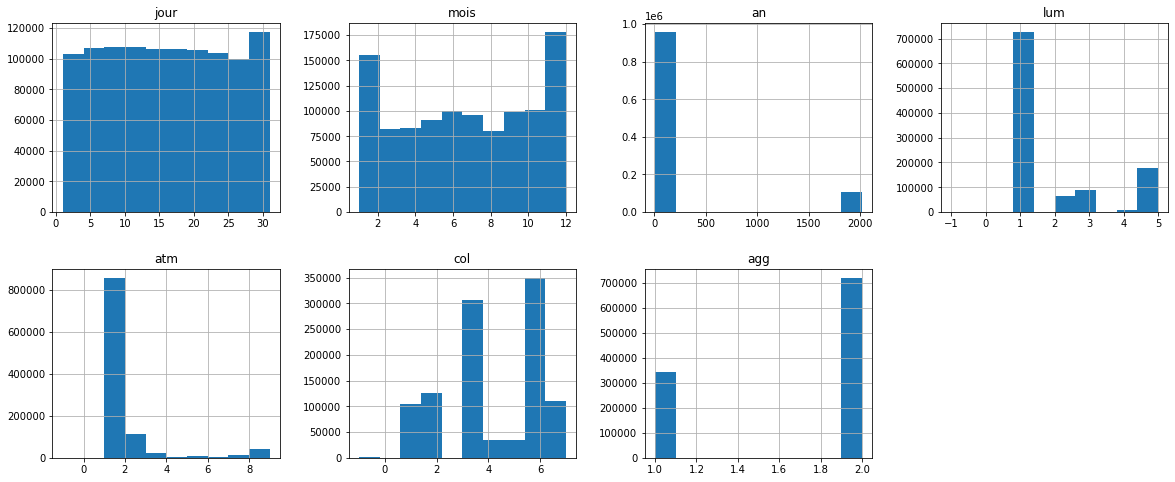

In [9]:
dfCarac[['jour', 'mois', 'an', 'lum', 'atm', 'col', 'agg']].hist(figsize=(20, 8), layout=(2, 4));

### -Table Lieux-

In [15]:
dfLieux.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,...,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma,grav
0,0,0,201600000001,3.0,39,NaN,NaN,2.0,0.0,NaN,...,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,3
1,1,1,201600000002,3.0,39,NaN,NaN,1.0,0.0,NaN,...,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0.0,NaN,3
2,2,2,201600000003,3.0,1,NaN,NaN,2.0,2.0,NaN,...,1.0,3.0,0.0,68.0,2.0,0.0,3.0,99.0,NaN,3


In [12]:
dfLieux[['nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'env1']].describe()

,nbv,vosp,prof,plan,surf,infra,situ,env1
count,1.062322e+06,1.062292e+06,1.063104e+06,1.062772e+06,1.063129e+06,1.059645e+06,1.060083e+06,953029.000000
mean,2.099984e+00,1.342983e-01,1.155437e+00,1.210787e+00,1.260633e+00,4.799305e-01,1.224638e+00,38.230840
std,1.516156e+00,5.621275e-01,6.102975e-01,7.209365e-01,9.412922e-01,1.466913e+00,8.621112e-01,48.059472
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000
25%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000
50%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000
75%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,99.000000
max,9.900000e+01,3.000000e+00,4.000000e+00,4.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,99.000000


In [5]:
dfLieux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065053 entries, 0 to 1065052
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0.1  1065053 non-null  int64  
 1   Unnamed: 0    1065053 non-null  int64  
 2   Num_Acc       1065053 non-null  int64  
 3   catr          1065052 non-null  float64
 4   voie          960441 non-null   object 
 5   v1            429229 non-null   float64
 6   v2            46379 non-null    object 
 7   circ          1063479 non-null  float64
 8   nbv           1062322 non-null  float64
 9   pr            589569 non-null   object 
 10  pr1           587750 non-null   object 
 11  vosp          1062292 non-null  float64
 12  prof          1063104 non-null  float64
 13  plan          1062772 non-null  float64
 14  lartpc        902631 non-null   object 
 15  larrout       952212 non-null   object 
 16  surf          1063129 non-null  float64
 17  infra         1059645 non-n

In [11]:
### Proportion of NA by variable
dfLieux.isnull().sum() * 100 / len(dfLieux)

Unnamed: 0.1     0.000000
Unnamed: 0       0.000000
Num_Acc          0.000000
catr             0.000094
voie             9.822234
v1              59.698813
v2              95.645381
circ             0.147786
nbv              0.256419
pr              44.644163
pr1             44.814953
vosp             0.259236
prof             0.182996
plan             0.214168
lartpc          15.250133
larrout         10.594872
surf             0.180648
infra            0.507768
situ             0.466643
env1            10.518162
vma             89.992611
grav             0.000000
dtype: float64

In [58]:
# Unique modalities by variable
print('nbv:', len(dfLieux.nbv.value_counts()))
print('vosp:', len(dfLieux.vosp.value_counts()))
print('prof:', len(dfLieux.vosp.value_counts()))
print('plan:', len(dfLieux.plan.value_counts()))
print('pr:', len(dfLieux.pr.value_counts()))
print('pr1:', len(dfLieux.pr1.value_counts()))
print('lartpc:', len(dfLieux.lartpc.value_counts()))
print('larrout:', len(dfLieux.larrout.value_counts()))
print('surf:', len(dfLieux.surf.value_counts()))
print('infra:', len(dfLieux.infra.value_counts()))
print('situ:', len(dfLieux.situ.value_counts()))
print('env1:', len(dfLieux.env1.value_counts()))

nbv: 54
vosp: 5
prof: 5
plan: 6
pr: 1472
pr1: 3733
lartpc: 451
larrout: 692
surf: 11
infra: 11
situ: 9
env1: 3


In [24]:
# Values by variable
print(dfLieux.nbv.value_counts())
print(dfLieux.vosp.value_counts())
print(dfLieux.prof.value_counts())
print(dfLieux.plan.value_counts())
print(dfLieux.pr.value_counts())
print(dfLieux.pr1.value_counts())
print(dfLieux.lartpc.value_counts())
print(dfLieux.larrout.value_counts())
print(dfLieux.surf.value_counts())
print(dfLieux.infra.value_counts())
print(dfLieux.situ.value_counts())
print(dfLieux.env1.value_counts())

 2.0     600628
 1.0     125816
 0.0     111739
 4.0     102096
 3.0      82852
 6.0      19548
 5.0      11066
 8.0       3994
 7.0       1418
-1.0       1110
 10.0       838
 9.0        417
 20.0       241
 50.0       158
 11.0       120
 12.0       100
 40.0        30
 30.0        27
 13.0        18
 25.0        14
 21.0        11
 26.0         9
 15.0         8
 90.0         7
 14.0         6
 24.0         6
 70.0         5
 22.0         5
 60.0         3
 31.0         3
 45.0         2
 27.0         2
 17.0         2
 16.0         2
 53.0         2
 86.0         1
 91.0         1
 18.0         1
 84.0         1
 39.0         1
 54.0         1
 29.0         1
 62.0         1
 99.0         1
 44.0         1
 42.0         1
 65.0         1
 36.0         1
 41.0         1
 33.0         1
 52.0         1
 76.0         1
 28.0         1
 23.0         1
Name: nbv, dtype: int64
 0.0    992708
 3.0     30159
 1.0     23819
 2.0     14658
-1.0       948
Name: vosp, dtype: int64
 1.0    8137

In [47]:
# Equilibre variables
print(dfLieux.vosp.value_counts(normalize=True))
print(dfLieux.env1.value_counts(normalize=True))

0.0     0.568222
99.0    0.384745
3.0     0.047033
Name: env1, dtype: float64

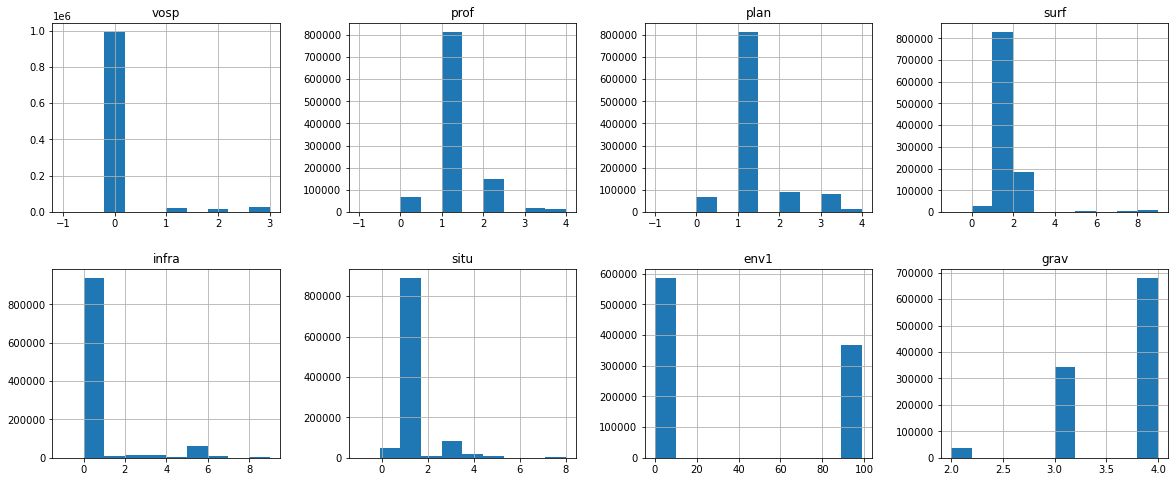

In [10]:
dfLieux[['vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'env1', 'grav']].hist(figsize=(20, 8), layout=(2, 4));

##### -Table Usagers-

In [20]:
dfUsagers.head(3)

,Unnamed: 0,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh,id_vehicule,secu1,secu2,secu3
0,0,201600000001,1.0,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02,NaN,NaN,NaN,NaN
1,1,201600000001,1.0,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01,NaN,NaN,NaN,NaN
2,2,201600000002,1.0,1,3,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01,NaN,NaN,NaN,NaN


In [14]:
### Proportion of NA by variable
dfUsagers.isnull().sum() * 100 / len(dfUsagers)

Unnamed: 0.1     0.000000
Unnamed: 0       0.000000
Num_Acc          0.000000
place            5.172430
catu             0.000000
grav             0.000000
sexe             0.000000
trajet           0.020752
secu            12.384503
locp             2.367645
actp             2.371888
etatp            2.370039
an_nais          0.101577
num_veh          0.000000
id_vehicule     89.990535
secu1           89.990535
secu2           89.990535
secu3           89.990535
grav2            0.000000
dtype: float64

##### -Table Vehicles-

In [21]:
dfVehicules.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor,grav
0,0,0,201600000001,0.0,7,0.0,0.0,0.0,1.0,1.0,B02,NaN,NaN,3
1,1,1,201600000001,0.0,2,0.0,0.0,0.0,7.0,15.0,A01,NaN,NaN,3
2,2,2,201600000002,0.0,7,0.0,6.0,0.0,1.0,1.0,A01,NaN,NaN,3


### Graphs

In [5]:
# Gravity variable in Carac dataframe
pd.DataFrame({'prop':dfCarac.grav.value_counts(normalize=True),
              'count':dfCarac.grav.value_counts()})

,prop,count
2,0.571342,608509
3,0.373156,397431
4,0.055502,59113


In [26]:
# Gravity variable in Lieux dataframe
pd.DataFrame({'prop':dfLieux.grav.value_counts(normalize=True),
              'count':dfLieux.grav.value_counts()})

,prop,count
2,0.571342,608509
3,0.373156,397431
4,0.055502,59113


$\color{#0005FF}{\text{Both dataframes Carac and Lieux have the same amount of accidents, they also have the same accident gravity distribution}}$

##### -Table Carac-

### Year

C:\Users\Megaport\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


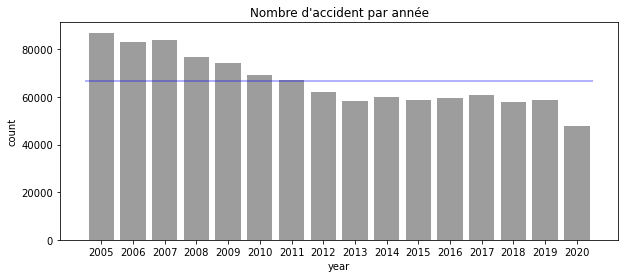

In [51]:
# Display plots
plt.figure(figsize=(10, 4))
sns.countplot(dfCarac['year'], palette=['#9D9D9D'])
plt.hlines(y=len(dfCarac['year'])/16, xmin=-0.5, xmax=15.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par année");
# It seems that the number of accident never stops decreasing year after year
# The observable large decreases seem to be during 2007-2008, 2011-2012 and 2019-2020
# The number of accident seemed to be stable between 2013 and 2019

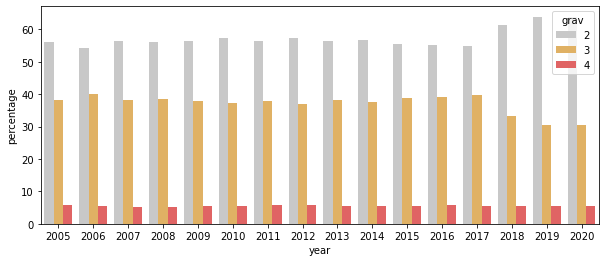

In [52]:
# Initiating dataframe grouped by month
dfCaracGpByYear = (dfCarac.groupby(['year'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="year", y="percentage", hue="grav", data=dfCaracGpByYear, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# It seems that the gravity is less important during 2018 to 2020

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\4164099579.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


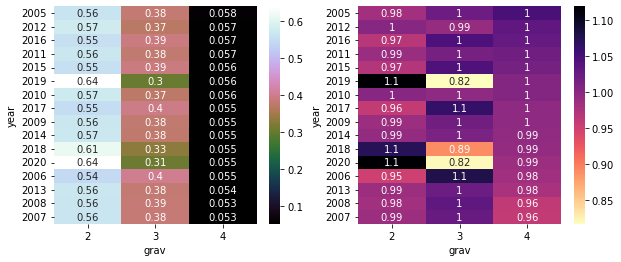

In [91]:
# data-management
dfYearGrav = pd.crosstab(dfCarac['year'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfYearGravRaw = pd.crosstab(dfCarac['year'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfYearGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfYearGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Even though 2018 to 2020 have the largest proportions of accident gravity 3, they also have the lowest gravity 3 ones
# It seems that the state has focused on reducing the overall number of accident but not the gravity of accidents

### Months

C:\Users\Megaport\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


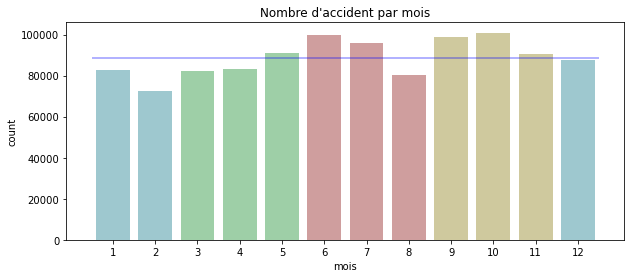

In [54]:
# Display plots
plt.figure(figsize=(10, 4))
sns.countplot(dfCarac['mois'], 
             palette=['#96CED7', '#96CED7', 
                   '#96D7A2', '#96D7A2', '#96D7A2', 
                   '#D79696', '#D79696', '#D79696', 
                   '#D7CF96', '#D7CF96', '#D7CF96', 
                   '#96CED7'])
plt.hlines(y=len(dfCarac['mois'])/12, xmin=-0.5, xmax=11.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par mois");
# On peut observer que les mois de juin, juillet, septembre et octobre semblent avoir le plus d'accidents
# On peut observer que le mois de février compte le moins d'accidents mais il comporte aussi 28 jours

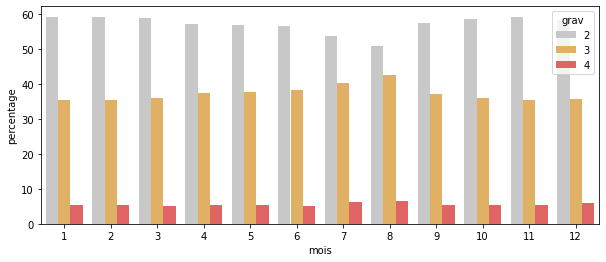

In [55]:
# Initiating dataframe grouped by month
dfCaracGpByMonth = (dfCarac.groupby(['mois'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="mois", y="percentage", hue="grav", data=dfCaracGpByMonth, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# It seems that the gravity of accident is larger during the weekend compared to the week

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\2321808434.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


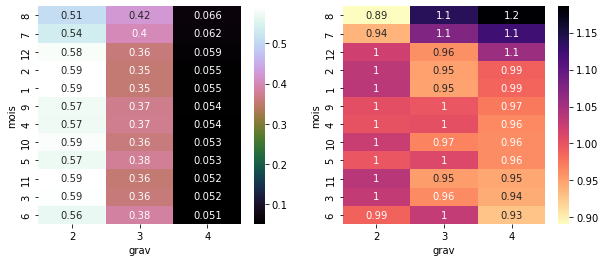

In [92]:
# data-management
dfMonthGrav = pd.crosstab(dfCarac['mois'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfMonthGravRaw = pd.crosstab(dfCarac['mois'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfMonthGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfMonthGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# It seems that the largest proportion of accident gravity 2 & 3 happen during august and july

### Month day

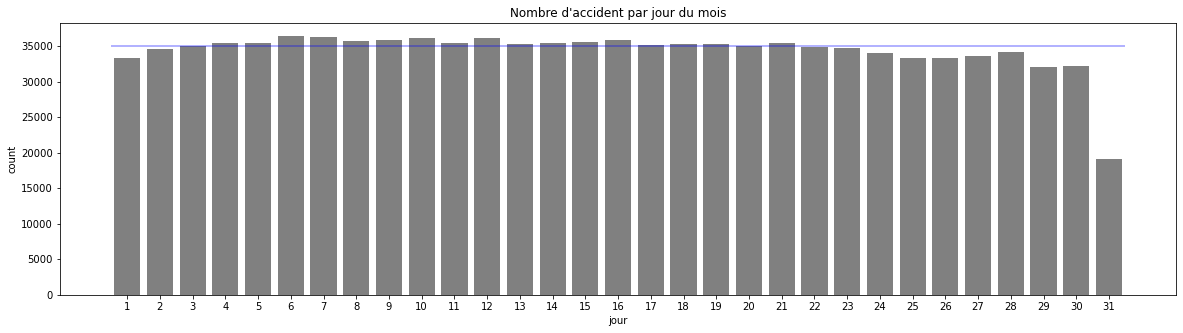

In [60]:
plt.figure(figsize=(20, 5))
sns.countplot(x=dfCarac['jour'], color='grey')
plt.hlines(y=len(dfCarac['jour'])/(365/12), xmin=-0.5, xmax=30.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par jour du mois");
# With no surprise, day 31 has twice as less accidents as other days of the month because it only occurs 1 months out of 2

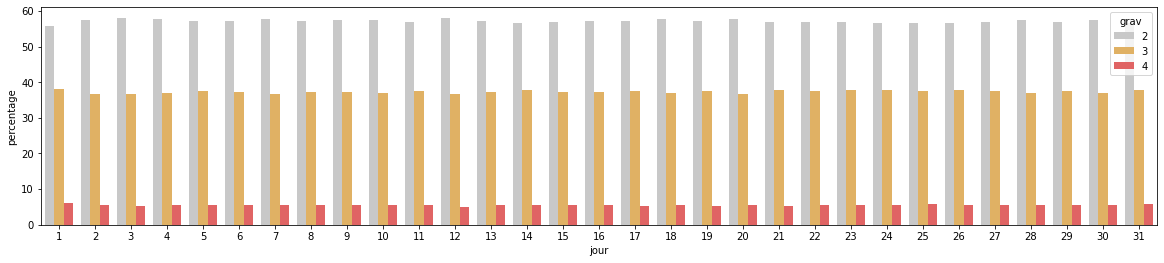

In [61]:
# Initiating dataframe grouped by weekday
dfCaracGpByMonthday = (dfCarac.groupby(['jour'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="jour", y="percentage", hue="grav", data=dfCaracGpByMonthday, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Hard to read this figure but no trend seems to be seen

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\1007389573.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


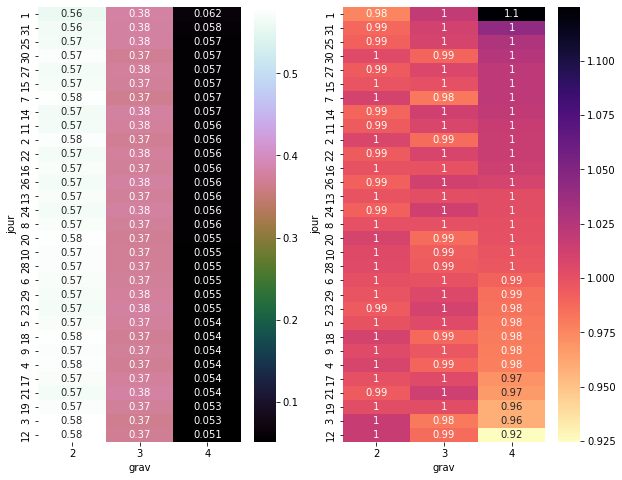

In [93]:
# data-management
dfMonthdayGrav = pd.crosstab(dfCarac['jour'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfMonthdayGravRaw = pd.crosstab(dfCarac['jour'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.heatmap(dfMonthdayGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfMonthdayGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Geniunly no trend drawn

### Weekday

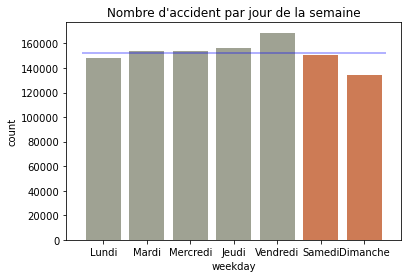

In [63]:
sns.countplot(x=dfCarac['weekday'], 
             palette=['#A0A491', '#A0A491', '#A0A491', '#A0A491', '#A0A491', '#E17441', '#E17441'])
plt.hlines(y=len(dfCarac['weekday'])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
plt.xticks(np.arange(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.title("Nombre d'accident par jour de la semaine");
# It seems that the friday is the accident day

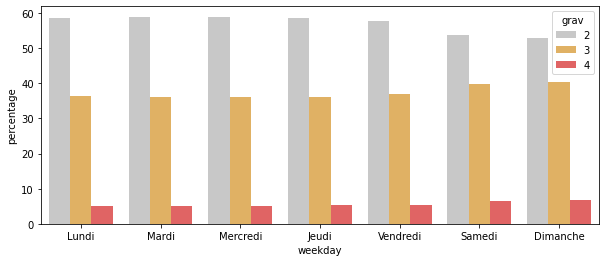

In [64]:
# Initiating dataframe grouped by weekday
dfCaracGpByWeekday = (dfCarac.groupby(['weekday'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="weekday", y="percentage", hue="grav", data=dfCaracGpByWeekday, 
             palette=['#C8C8C8','#F4B650','#F45050'])
ax.set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']);
# It seems that the gravity of accident is larger during the weekend compared to the week

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\1330191047.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


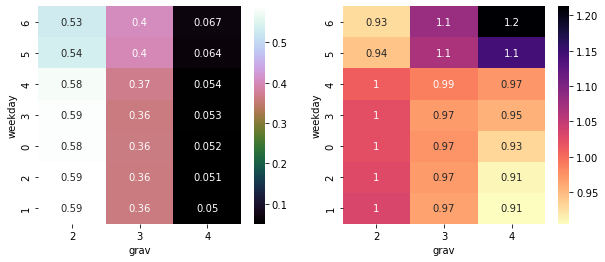

In [94]:
# data-management
dfWeekdayGrav = pd.crosstab(dfCarac['weekday'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfWeekdayGravRaw = pd.crosstab(dfCarac['weekday'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfWeekdayGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfWeekdayGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Actually, the largest proportion of accident gravity 2 is during sunday then saturday

### Hour of the day

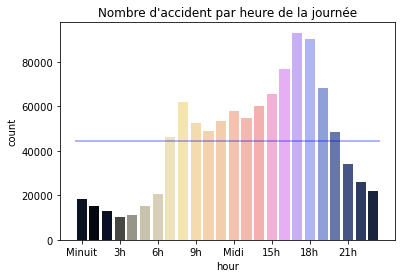

In [75]:
sns.countplot(x=dfCarac['hour'], 
             palette=['#090F23', '#03060F', '#040D29', '#484743', '#999588', '#CDC5A9', 
                     '#DDD3B0', '#F5E7B1', '#FFECA4', '#FFDEA4', '#FFD2A4', '#FFCBA4', 
                     '#FFBDA4', '#FFAFA4', '#FFA4A4', '#FFA4D6', '#EDA4FF', '#C2A4FF', 
                     '#A4AAFF', '#839AE5', '#5B71B8', '#3C508F', '#26366A', '#152043'])
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21], ['Minuit', '3h', '6h', '9h', 'Midi', '15h', '18h', '21h'])
plt.title("Nombre d'accident par heure de la journée")
plt.hlines(y=len(dfCarac['hour'])/24, xmin=-0.5, xmax=23.5, color='blue', alpha=0.4);
# It seems that most accident happen between 4pm and 7pm which is when people usually go back home and the sun goes down
# At 7am, the number of accident drastically increase and really goes down after 8pm

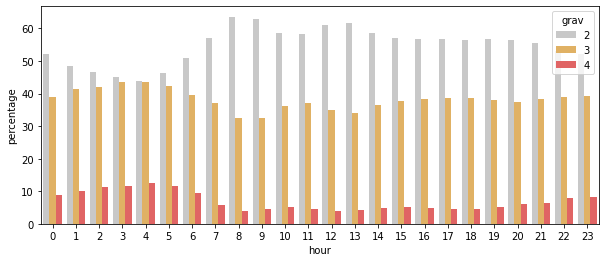

In [33]:
# Initiating dataframe grouped by hour
dfCaracGpByHour = (dfCarac.groupby(['hour'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="hour", y="percentage", hue="grav", data=dfCaracGpByHour, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Wow, it seems that the gravity of accidents is worst during the night (22pm-6am)
# More than 5% gravity 2 during the night against less than 4% during full day

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\1923995353.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


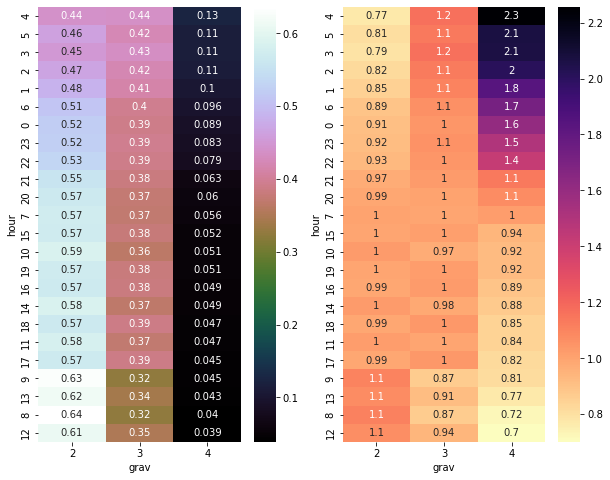

In [95]:
# data-management
dfHourGrav = pd.crosstab(dfCarac['hour'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfHourGravRaw = pd.crosstab(dfCarac['hour'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.heatmap(dfHourGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfHourGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Proposition: creating a full night variable [0-6am] (yes/no)

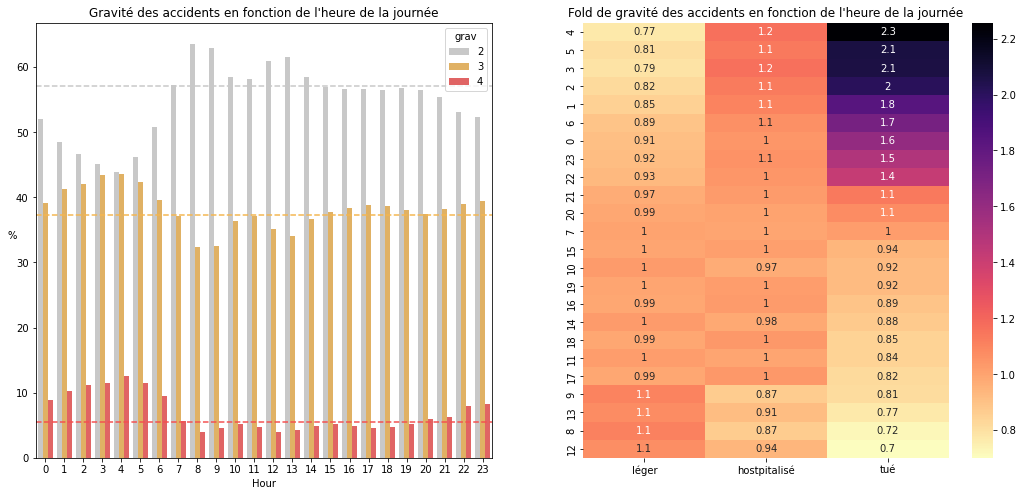

In [141]:
# Initiating gravity proportion of CCA hour variable
propGrav = dfCarac['grav'].value_counts(normalize=True)

# Initiating dataframe grouped by hour
dfCaracGpByHour = (dfCarac.groupby(['hour'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    # 1st plot
sns.barplot(x="hour", y="percentage", hue="grav", data=dfCaracGpByHour, 
             palette=['#C8C8C8','#F4B650','#F45050'], ax=ax[0])
        # text outside the plot
# ax[0].set_xticks(np.arange(0, 5, 1))
# ax[0].set_xticklabels(['day', 'dawn', 'night\nwo light', 'night\nwi light not lit', 'night\n wi light lit'])
ax[0].set_title('Gravité des accidents en fonction de l\'heure de la journée')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('%', rotation=0)
        # adding horizontal overall proportion by gravity
ax[0].axhline(y=propGrav.loc[2]*100, color='#C8C8C8', linestyle='--')
ax[0].axhline(y=propGrav.loc[3]*100, color='#F4B650', linestyle='--')
ax[0].axhline(y=propGrav.loc[4]*100, color='#F45050', linestyle='--')
    # 2nd plot
sns.heatmap(dfHourGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1])
        # text outside the plot
ax[1].set_xticks([0.5, 1.5, 2.5])
ax[1].set_xticklabels(['léger', 'hostpitalisé', 'tué'])
ax[1].set_title('Fold de gravité des accidents en fonction de l\'heure de la journée')
ax[1].set_xlabel('')
ax[1].set_ylabel('');

### Lum

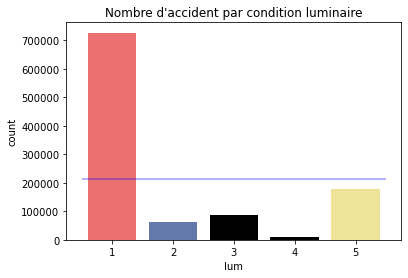

In [74]:
sns.countplot(x=dfCarac['lum'][(dfCarac['lum']!=-1)], 
             palette=['#FF5D5D', '#5774B8', '#000000', '#000000', '#FDEC8B'])
plt.title("Nombre d'accident par condition luminaire")
plt.hlines(y=len(dfCarac['lum'][(dfCarac['lum']!=-1)])/5, xmin=-0.5, xmax=4.5, color='blue', alpha=0.4);
# It seems that most accident happen during the full day

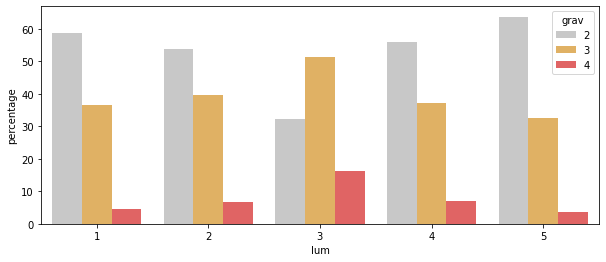

In [75]:
# Initiating dataframe grouped by hour
dfCaracGpByLum = (dfCarac[(dfCarac['lum']!=-1)].groupby(['lum'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plots
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="lum", y="percentage", hue="grav", data=dfCaracGpByLum, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Wow, it seems that the gravity of accidents is worst during the night (22pm-6am)
# More than 5% gravity 2 during the night against less than 4% during full day

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\1495730437.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


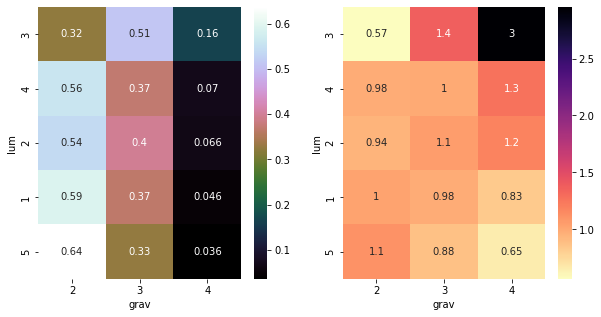

In [96]:
# data-management
dfLumGrav = pd.crosstab(dfCarac['lum'][(dfCarac['lum']!=-1)], dfCarac['grav'][(dfCarac['lum']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfLumGravRaw = pd.crosstab(dfCarac['lum'][(dfCarac['lum']!=-1)], dfCarac['grav'][(dfCarac['lum']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfLumGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfLumGrav.apply(lambda x: x/dfCarac['grav'][(dfCarac['lum']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# The night without public lightning seems to have a drastic increase of gravity 2 and 3 accidents rate (10% and 44%)!
# Then the two other cases where no much light is on have interesting gravity 2 increase accident rates

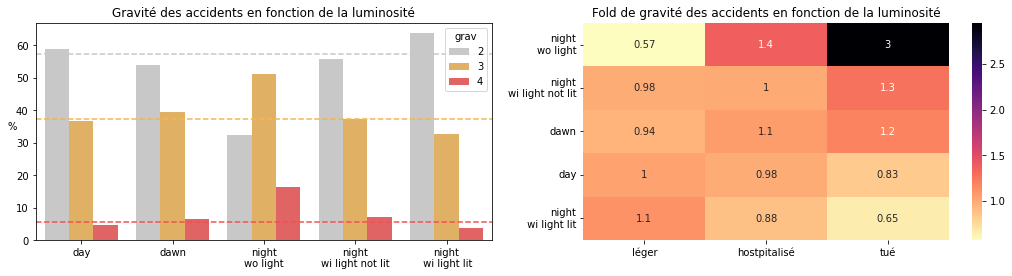

In [136]:
# Initiating gravity proportion of CCA lum variable
propGrav = dfCarac['grav'][(dfCarac['lum']!=-1)].value_counts(normalize=True)

# Initiating dataframe grouped by hour
dfCaracGpByLum = (dfCarac[(dfCarac['lum']!=-1)].groupby(['lum'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    # 1st plot
sns.barplot(x="lum", y="percentage", hue="grav", data=dfCaracGpByLum, 
             palette=['#C8C8C8','#F4B650','#F45050'], ax=ax[0])
        # adding horizontal overall proportion by gravity
ax[0].axhline(y=propGrav.loc[2]*100, color='#C8C8C8', linestyle='--')
ax[0].axhline(y=propGrav.loc[3]*100, color='#F4B650', linestyle='--')
ax[0].axhline(y=propGrav.loc[4]*100, color='#F45050', linestyle='--')
        # text outside the plot
ax[0].set_xticks(np.arange(0, 5, 1))
ax[0].set_xticklabels(['day', 'dawn', 'night\nwo light', 'night\nwi light not lit', 'night\n wi light lit'])
ax[0].set_title('Gravité des accidents en fonction de la luminosité')
ax[0].set_xlabel('')
ax[0].set_ylabel('%', rotation=0)
    # 2nd plot
sns.heatmap(dfLumGrav.apply(lambda x: x/dfCarac['grav'][(dfCarac['lum']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1])
        # text outside the plot
ax[1].set_xticks([0.5, 1.5, 2.5])
ax[1].set_xticklabels(['léger', 'hostpitalisé', 'tué'])
ax[1].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax[1].set_yticklabels(['night\nwo light', 'night\nwi light not lit', 'dawn', 'day', 'night\n wi light lit'], rotation=0)
ax[1].set_title('Fold de gravité des accidents en fonction de la luminosité')
ax[1].set_xlabel('')
ax[1].set_ylabel('');

### Atm

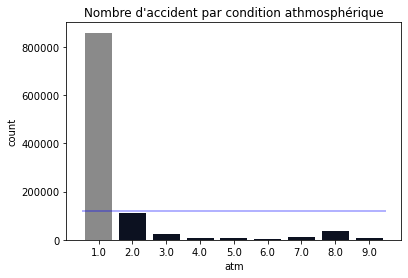

In [54]:
sns.countplot(x=dfCarac['atm'][(dfCarac['atm']!=-1)], 
             palette=['#8A8A8A', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23', 
                     '#090F23', '#090F23', '#090F23'])
plt.title("Nombre d'accident par condition athmosphérique")
plt.hlines(y=len(dfCarac['atm'][(dfCarac['atm']!=-1)])/9, xmin=-0.5, xmax=8.5, color='blue', alpha=0.4);
# It seems that most accident happen with normal atmospheric conditions, then light rain

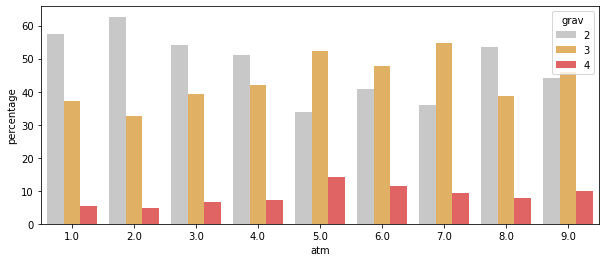

In [35]:
# Initiating dataframe grouped by hour
dfCaracGpByAtm = (dfCarac[(dfCarac['atm']!=-1)].groupby(['atm'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="atm", y="percentage", hue="grav", data=dfCaracGpByAtm, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Wow, it seems that the gravity of accidents is worst during fog/smoke, strong wind/storm, dazzling weather and 'other'

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\1991586258.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


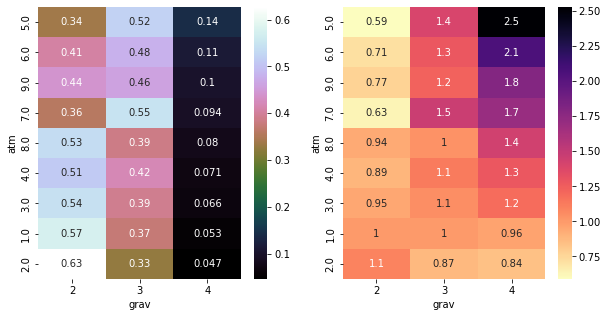

In [97]:
# data-management
dfAtmGrav = pd.crosstab(dfCarac['atm'][(dfCarac['atm']!=-1)], dfCarac['grav'][(dfCarac['atm']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfAtmGravRaw = pd.crosstab(dfCarac['atm'][(dfCarac['atm']!=-1)], dfCarac['grav'][(dfCarac['atm']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfAtmGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfAtmGrav.apply(lambda x: x/dfCarac['grav'][(dfCarac['atm']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# These graphs confirm that both gravity 2 and 3 are increase for groups 5, 6, 7 and 9

### Col

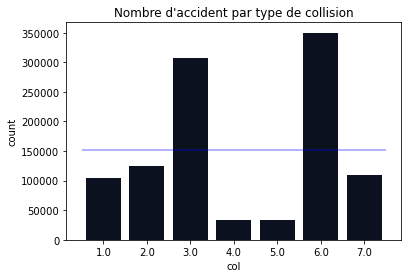

In [89]:
sns.countplot(x=dfCarac['col'][(dfCarac['col']!=-1)], 
             palette=['#090F23', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23'])
plt.title("Nombre d'accident par type de collision")
plt.hlines(y=len(dfCarac['col'][(dfCarac['col']!=-1)])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
# Other collision and by the side are the most counted
# It is quite disturbing to see that the most filled class is the group 'other'
# There is a feeling that this variable was not well defined or filled

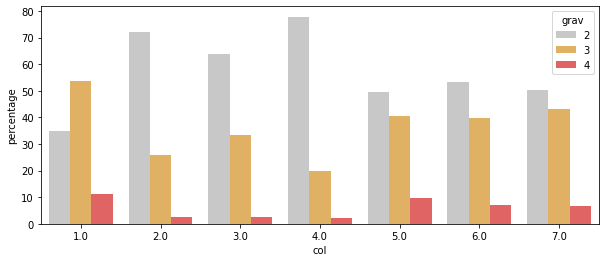

In [36]:
# Initiating dataframe grouped by hour
dfCaracGpByCol = (dfCarac[(dfCarac['col']!=-1)].groupby(['col'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="col", y="percentage", hue="grav", data=dfCaracGpByCol, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Les groupes 2, 3 et 4 sont très peu impactés en termes de gravité alors que les groupes 1, 6 et 7 semblent impactants

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\2332676309.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


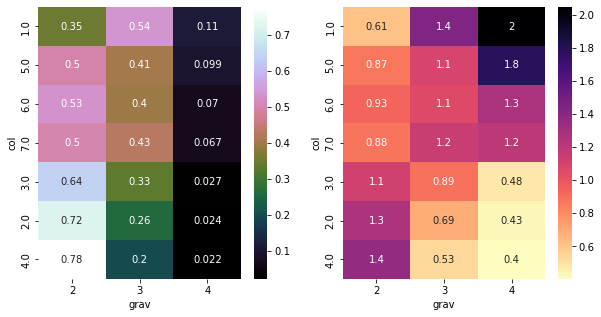

In [98]:
# data-management
dfColGrav = pd.crosstab(dfCarac['col'][(dfCarac['col']!=-1)], dfCarac['grav'][(dfCarac['col']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfColGravRaw = pd.crosstab(dfCarac['col'][(dfCarac['col']!=-1)], dfCarac['grav'][(dfCarac['col']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfColGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfColGrav.apply(lambda x: x/dfCarac['grav'][(dfCarac['col']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# La collision de type 1 est celle qui maximise les accidents de gravité 3 avec un fort taux de gravité 2
# Les collisions de type 6 et 7 sont celles qui maximisent les accidents de gravité 2

### Date

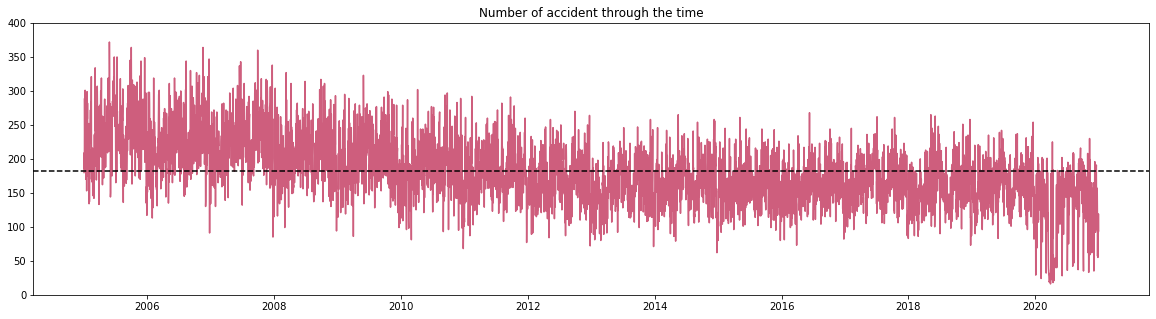

In [40]:
# Initiating variable
varDate = dfCarac.date.value_counts().sort_index()

# Display plot
plt.figure(figsize=(20, 5))
plt.plot(varDate.index, varDate, color='#CE5E7D')
plt.axhline(y=varDate.mean(), color='k', linestyle='--')
plt.title('Number of accident through the time')
plt.ylim([0, 400]);

104.1254277891855
68.00667351129364
10.12208904109589


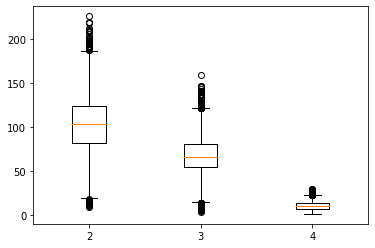

In [41]:
# Distribution nombre d'accidents par gravité
plt.boxplot([varDateGrav2, varDateGrav3, varDateGrav4])
plt.xticks(ticks=[1, 2, 3], labels=['2', '3', '4']);

# Mean accidents by gravity
print(varDateGrav2.mean())
print(varDateGrav3.mean())
print(varDateGrav4.mean())

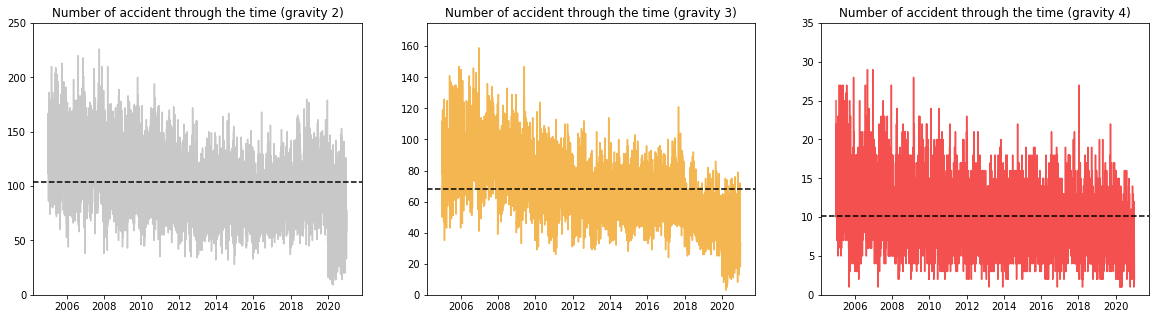

In [46]:
# Initiating variables
varDateGrav2 = dfCarac[(dfCarac.grav==2)].date.value_counts().sort_index()
varDateGrav3 = dfCarac[(dfCarac.grav==3)].date.value_counts().sort_index()
varDateGrav4 = dfCarac[(dfCarac.grav==4)].date.value_counts().sort_index()

# Display plots by gravity
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(varDateGrav2.index, varDateGrav2, color='#C8C8C8')
plt.axhline(y=varDateGrav2.mean(), color='k', linestyle='--')
plt.title('Number of accident through the time (gravity 2)')
plt.ylim([0, 250]);
plt.subplot(132)
plt.plot(varDateGrav3.index, varDateGrav3, color='#F4B650')
plt.axhline(y=varDateGrav3.mean(), color='k', linestyle='--')
plt.title('Number of accident through the time (gravity 3)')
plt.ylim([0, 175]);
plt.subplot(133)
plt.plot(varDateGrav4.index, varDateGrav4, color='#F45050')
plt.axhline(y=varDateGrav4.mean(), color='k', linestyle='--')
plt.title('Number of accident through the time (gravity 4)')
plt.ylim([0, 35]);

In [ ]:
# Initiating folds
dfDateGrav = pd.crosstab(dfCarac['date'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfDateGravLambda = dfDateGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1)
dfDateGravLambdaGrav2 = dfDateGravLambda[2].sort_index()
dfDateGravLambdaGrav3 = dfDateGravLambda[3].sort_index()
dfDateGravLambdaGrav4 = dfDateGravLambda[4].sort_index()

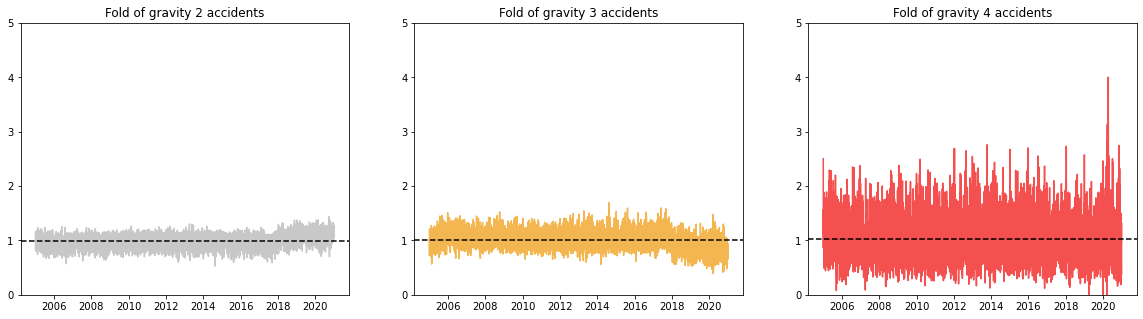

In [56]:
# Display folds by gravity
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(dfDateGravLambdaGrav2.index, dfDateGravLambdaGrav2, color='#C8C8C8')
plt.axhline(y=dfDateGravLambdaGrav2.mean(), color='k', linestyle='--')
plt.title('Fold of gravity 2 accidents')
plt.ylim([0, 5]);
plt.subplot(132)
plt.plot(dfDateGravLambdaGrav3.index, dfDateGravLambdaGrav3, color='#F4B650')
plt.axhline(y=dfDateGravLambdaGrav3.mean(), color='k', linestyle='--')
plt.title('Fold of gravity 3 accidents')
plt.ylim([0, 5]);
plt.subplot(133)
plt.plot(dfDateGravLambdaGrav4.index, dfDateGravLambdaGrav4, color='#F45050')
plt.axhline(y=dfDateGravLambdaGrav4.mean(), color='k', linestyle='--')
plt.title('Fold of gravity 4 accidents')
plt.ylim([0, 5]);
# There is a clear time-related event impacting gravity 4 accidents

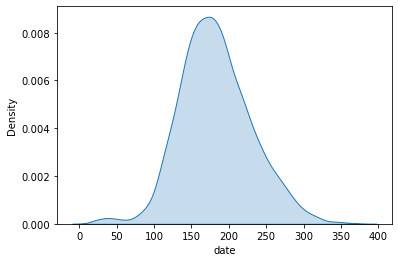

In [42]:
# Distribution analysis
sns.kdeplot(varDate, shade=True);

### Agg

In [39]:
print(dfCarac['agg'].value_counts())
print(dfCarac['agg'].value_counts(normalize=True))

2    720478
1    344575
Name: agg, dtype: int64
2    0.676471
1    0.323529
Name: agg, dtype: float64


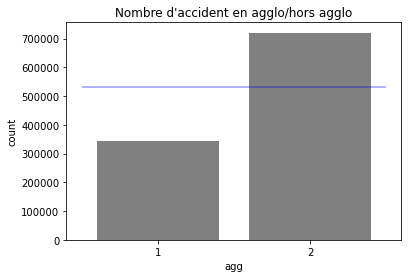

In [35]:
sns.countplot(x=dfCarac['agg'], color='grey')
plt.title("Nombre d'accident en agglo/hors agglo")
plt.hlines(y=len(dfCarac['agg'])/2, xmin=-0.5, xmax=1.5, color='blue', alpha=0.4);
# Many accidents when there are 2 route tracks

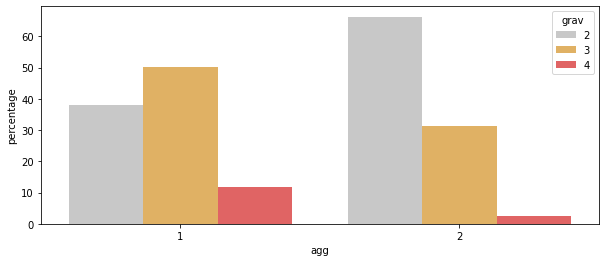

In [36]:
# Initiating dataframe grouped
dfCaracGpByAgg = (dfCarac.groupby(['agg'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="agg", y="percentage", hue="grav", data=dfCaracGpByAgg, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Les accidents semblent plus graves hors agglomération

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\3824792039.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


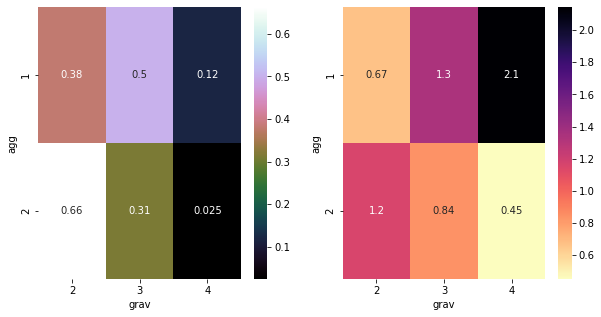

In [126]:
# data-management
dfAggGrav = pd.crosstab(dfCarac['agg'], dfCarac['grav'], normalize=0).sort_values(by=4, ascending=False)
dfAggGravRaw = pd.crosstab(dfCarac['agg'], dfCarac['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfAggGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfAggGrav.apply(lambda x: x/dfCarac['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# 2 fois plus d'accidents de gravité 2 hors agglomération

### nbv

In [78]:
dfLieux.nbv[(dfLieux.nbv<8) & (dfLieux.nbv>-1)].value_counts()

2.0    600628
1.0    125816
0.0    111739
4.0    102096
3.0     82852
6.0     19548
5.0     11066
7.0      1418
Name: nbv, dtype: int64

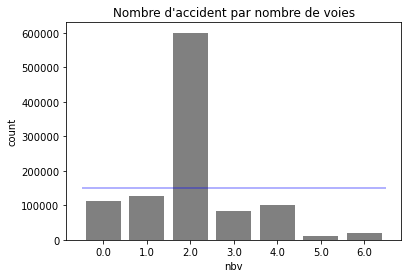

In [83]:
sns.countplot(x=dfLieux.nbv[(dfLieux.nbv<7) & (dfLieux.nbv>-1)], color='grey')
plt.title("Nombre d'accident par nombre de voies")
plt.hlines(y=len(dfLieux['nbv'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
# Many accidents when there are 2 route tracks

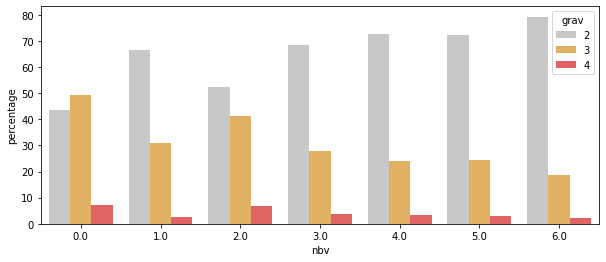

In [37]:
# Initiating dataframe grouped
dfCaracGpByNbv = (dfLieux[(dfLieux.nbv<7) & (dfLieux.nbv>-1)].groupby(['nbv'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="nbv", y="percentage", hue="grav", data=dfCaracGpByNbv, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# Les groupes 0 et 2 semblent avoir un taux élevé d'accidents gravité 2 et 3

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\3719978342.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


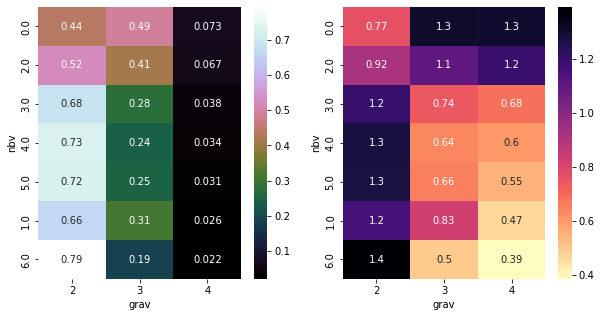

In [99]:
# data-management
dfNbvGrav = pd.crosstab(dfLieux.nbv[(dfLieux.nbv<7) & (dfLieux.nbv>-1)], dfCarac['grav'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)], normalize=0).sort_values(by=4, ascending=False)
dfNbvGravRaw = pd.crosstab(dfLieux.nbv[(dfLieux.nbv<7) & (dfLieux.nbv>-1)], dfCarac['grav'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfNbvGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfNbvGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Les groupes 0 et 2 semblent avoir un taux élevé d'accidents gravité 2 et 3

### vosp

In [88]:
dfLieux.vosp[(dfLieux.vosp>-1)].value_counts(normalize=True)

0.0    0.935331
3.0    0.028416
1.0    0.022442
2.0    0.013811
Name: vosp, dtype: float64

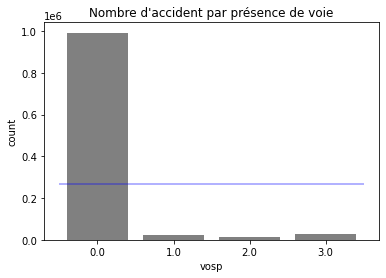

In [56]:
sns.countplot(x=dfLieux.vosp[(dfLieux.vosp>-1)], color='grey')
plt.title("Nombre d'accident par présence de voie")
plt.hlines(y=len(dfLieux['vosp'][(dfLieux.vosp>-1)])/4, xmin=-0.5, xmax=3.5, color='blue', alpha=0.4);
# Many accidents when there are no additional reserved track

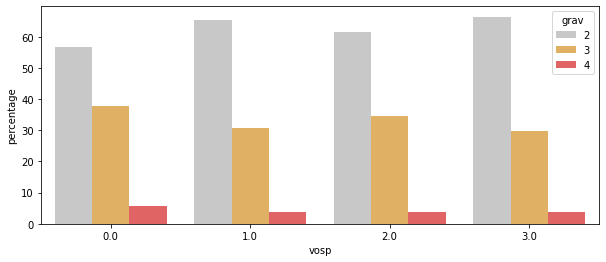

In [38]:
# Initiating dataframe grouped
dfCaracGpByVosp = (dfLieux[(dfLieux.vosp>-1)].groupby(['vosp'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="vosp", y="percentage", hue="grav", data=dfCaracGpByVosp, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\221437801.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


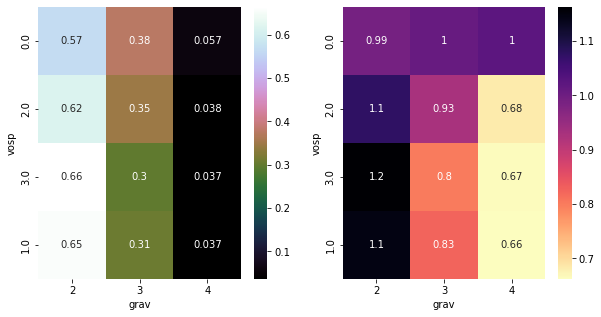

In [100]:
# data-management
dfVospGrav = pd.crosstab(dfLieux['vosp'][(dfLieux['vosp']!=-1)], dfLieux['grav'][(dfLieux['vosp']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfVospGravRaw = pd.crosstab(dfLieux['vosp'][(dfLieux['vosp']!=-1)], dfLieux['grav'][(dfLieux['vosp']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfVospGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfVospGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['vosp']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### prof

In [65]:
dfLieux.prof[(dfLieux.prof>-1)].value_counts()

1.0    813712
2.0    150021
0.0     65946
3.0     19009
4.0     14397
Name: prof, dtype: int64

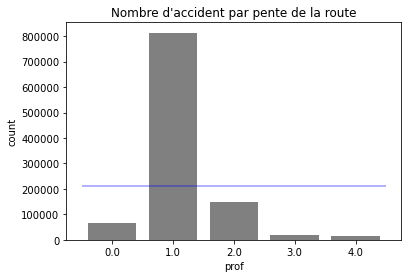

In [82]:
sns.countplot(x=dfLieux.prof[(dfLieux.prof>-1)], color='grey')
plt.title("Nombre d'accident par pente de la route")
plt.hlines(y=len(dfLieux['prof'][(dfLieux.prof>-1)])/5, xmin=-0.5, xmax=4.5, color='blue', alpha=0.4);
# Many accidents when there is a dish track

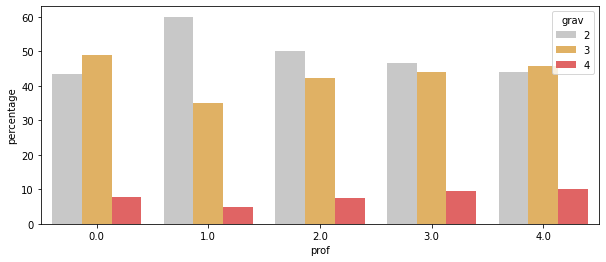

In [39]:
# Initiating dataframe grouped
dfCaracGpByProf = (dfLieux[(dfLieux.prof>-1)].groupby(['prof'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="prof", y="percentage", hue="grav", data=dfCaracGpByProf, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\380198740.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


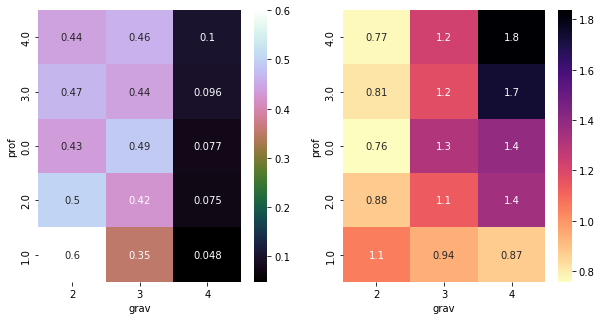

In [101]:
# data-management
dfProfGrav = pd.crosstab(dfLieux['prof'][(dfLieux['prof']!=-1)], dfLieux['grav'][(dfLieux['prof']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfProfGravRaw = pd.crosstab(dfLieux['prof'][(dfLieux['prof']!=-1)], dfLieux['grav'][(dfLieux['prof']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfProfGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfProfGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['prof']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### plan

In [67]:
dfLieux.plan[(dfLieux.plan>-1)].value_counts()

1.0    813581
2.0     88641
3.0     80514
0.0     66417
4.0     13601
Name: plan, dtype: int64

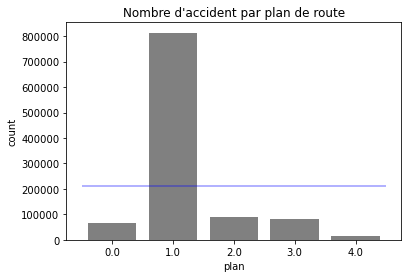

In [84]:
sns.countplot(x=dfLieux.plan[(dfLieux.plan>-1)], color='grey')
plt.title("Nombre d'accident par plan de route")
plt.hlines(y=len(dfLieux['plan'][(dfLieux.plan>-1)])/5, xmin=-0.5, xmax=4.5, color='blue', alpha=0.4);
# Many accidents when there are straight part

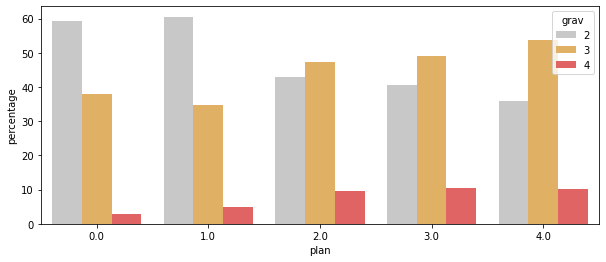

In [40]:
# Initiating dataframe grouped
dfCaracGpByPlan = (dfLieux[(dfLieux.plan>-1)].groupby(['plan'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="plan", y="percentage", hue="grav", data=dfCaracGpByPlan, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\30491044.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


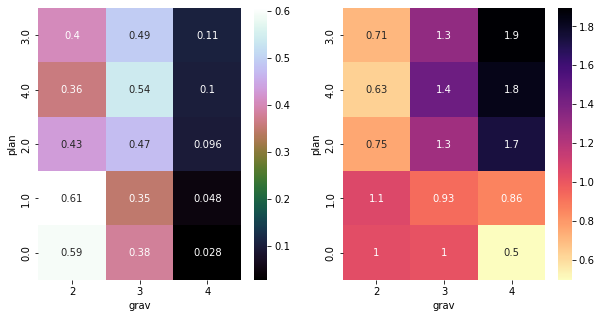

In [102]:
# data-management
dfPlanGrav = pd.crosstab(dfLieux['plan'][(dfLieux['plan']!=-1)], dfLieux['grav'][(dfLieux['plan']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfPlanGravRaw = pd.crosstab(dfLieux['plan'][(dfLieux['plan']!=-1)], dfLieux['grav'][(dfLieux['plan']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfPlanGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfPlanGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['plan']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### lartpc

In [7]:
dfLieux['lartpc'].describe()

count    902631.000000
mean          5.306772
std          23.053295
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         960.000000
Name: lartpc, dtype: float64

mean= 5
mean= 1


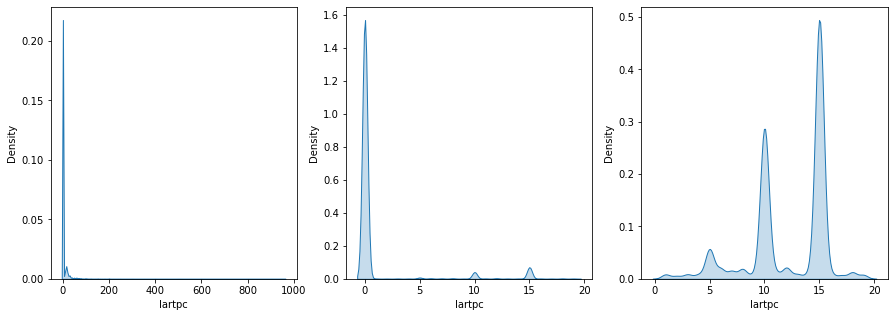

In [10]:
# Display distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(dfLieux['lartpc'], shade=True, ax=ax[0])
sns.kdeplot(dfLieux['lartpc'][(dfLieux['lartpc']<20)], shade=True, ax=ax[1])
sns.kdeplot(dfLieux['lartpc'][(dfLieux['lartpc']<20) & (dfLieux['lartpc']>0)], shade=True, ax=ax[2]);
print('mean=', round(dfLieux.lartpc.mean()))
print('mean=', round(dfLieux.lartpc[(dfLieux['lartpc']<20)].mean()))
# There are mainly 0 values and values around a mean of 5m but values around 15, 10 and 5 (mean of 1 when outliers removed)

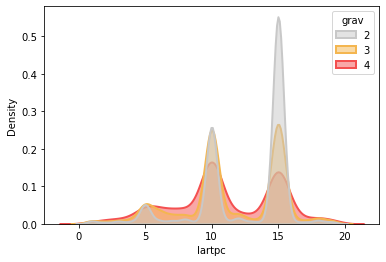

In [25]:
# Distribution by gravity
sns.kdeplot(
   data=dfLieux[(dfLieux['lartpc']<20) & (dfLieux['lartpc']>0)], x="lartpc", hue="grav",
   fill=True, common_norm=False, palette=['#C8C8C8','#F4B650','#F45050'],
   alpha=.5, linewidth=2
);

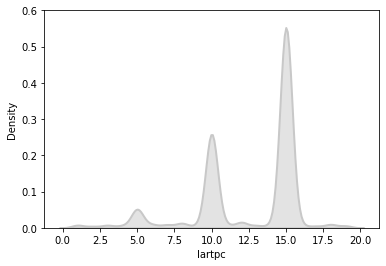

In [36]:
sns.kdeplot(
   data=dfLieux[(dfLieux['lartpc']<20) & (dfLieux['lartpc']>0) & (dfLieux['grav']==2)], x="lartpc",
   fill=True, common_norm=False, color=['#C8C8C8'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.6);

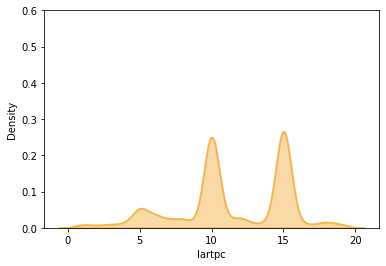

In [37]:
sns.kdeplot(
   data=dfLieux[(dfLieux['lartpc']<20) & (dfLieux['lartpc']>0) & (dfLieux['grav']==3)], x="lartpc",
   fill=True, common_norm=False, color=['#F4B650'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.6);

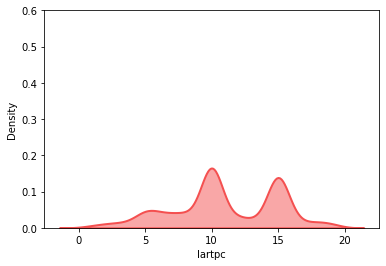

In [39]:
sns.kdeplot(
   data=dfLieux[(dfLieux['lartpc']<20) & (dfLieux['lartpc']>0) & (dfLieux['grav']==4)], x="lartpc",
   fill=True, common_norm=False, color=['#F45050'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.6);

### larrout

In [91]:
dfLieux.larrout[(dfLieux.larrout>-1)].describe()

count    907997.000000
mean         57.728218
std          64.560363
min           0.000000
25%           0.000000
50%          60.000000
75%          80.000000
max         999.000000
Name: larrout, dtype: float64

mean= 58
mean= 54


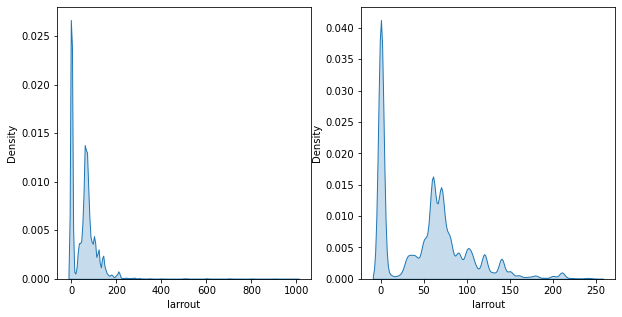

In [100]:
# Display distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(dfLieux.larrout[(dfLieux.larrout>-1)], shade=True, ax=ax[0])
sns.kdeplot(dfLieux.larrout[(dfLieux.larrout>-1) & (dfLieux.larrout<250)], shade=True, ax=ax[1]);
print('mean=', round(dfLieux.larrout[(dfLieux.larrout>-1)].mean()))
print('mean=', round(dfLieux.larrout[(dfLieux.larrout>-1) & (dfLieux.larrout<250)].mean()))
# It seems that most values are 0 and a mean around 58m (54m without outliers)

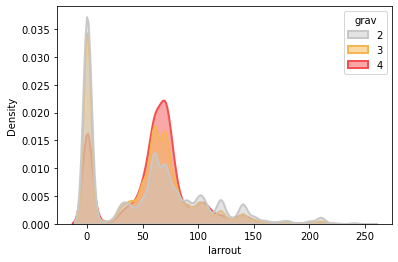

In [42]:
# Distribution by gravity
sns.kdeplot(
   data=dfLieux[(dfLieux.larrout>-1) & (dfLieux.larrout<250)], x="larrout", hue="grav",
   fill=True, common_norm=False, palette=['#C8C8C8','#F4B650','#F45050'],
   alpha=.5, linewidth=2,
);

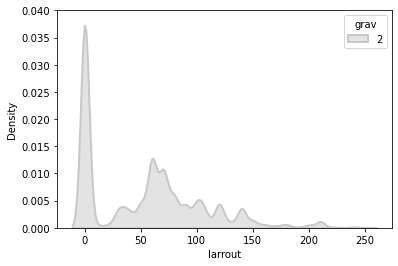

In [49]:
sns.kdeplot(
   data=dfLieux[(dfLieux.larrout>-1) & (dfLieux.larrout<250) & (dfLieux.grav==2)], x="larrout", hue="grav",
   fill=True, common_norm=False, palette=['#C8C8C8'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.04);

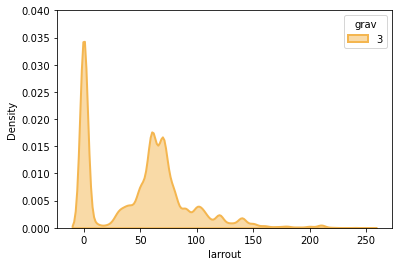

In [51]:
sns.kdeplot(
   data=dfLieux[(dfLieux.larrout>-1) & (dfLieux.larrout<250) & (dfLieux.grav==3)], x="larrout", hue="grav",
   fill=True, common_norm=False, palette=['#F4B650'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.04);

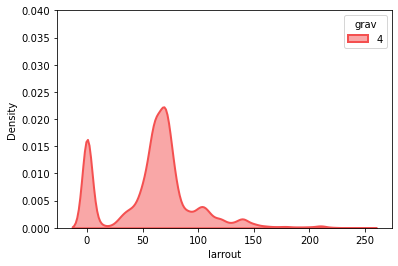

In [50]:
sns.kdeplot(
   data=dfLieux[(dfLieux.larrout>-1) & (dfLieux.larrout<250) & (dfLieux.grav==4)], x="larrout", hue="grav",
   fill=True, common_norm=False, palette=['#F45050'],
   alpha=.5, linewidth=2)
plt.ylim(0, 0.04);

### surf

In [86]:
#cat
dfLieux.surf[(dfLieux.surf>-1)].value_counts()

1.0    829791
2.0    183659
0.0     29139
7.0      6446
9.0      5742
5.0      3087
8.0      2577
3.0      1508
6.0       608
4.0       531
Name: surf, dtype: int64

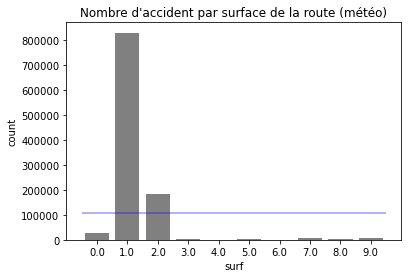

In [91]:
sns.countplot(x=dfLieux.surf[(dfLieux.surf>-1)], color='grey')
plt.title("Nombre d'accident par surface de la route (météo)")
plt.hlines(y=len(dfLieux['surf'][(dfLieux.vosp>-1)])/10, xmin=-0.5, xmax=9.5, color='blue', alpha=0.4);
# Many accidents when there is normal or wet meteo

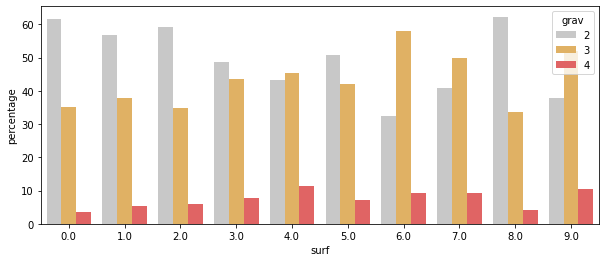

In [43]:
# Initiating dataframe grouped
dfCaracGpBySurf = (dfLieux[(dfLieux.surf>-1)].groupby(['surf'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="surf", y="percentage", hue="grav", data=dfCaracGpBySurf, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\4075801563.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


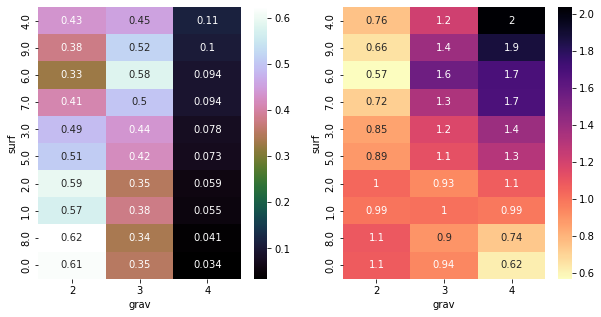

In [103]:
# data-management
dfSurfGrav = pd.crosstab(dfLieux['surf'][(dfLieux['surf']!=-1)], dfLieux['grav'][(dfLieux['surf']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfSurfGravRaw = pd.crosstab(dfLieux['surf'][(dfLieux['surf']!=-1)], dfLieux['grav'][(dfLieux['surf']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfSurfGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfSurfGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['surf']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### infra

In [93]:
#cat
dfLieux.infra[(dfLieux.infra>-1)].value_counts()

0.0    938199
5.0     62673
3.0     16361
2.0     15423
1.0      9440
6.0      7308
9.0      4072
4.0      3770
8.0       837
7.0       639
Name: infra, dtype: int64

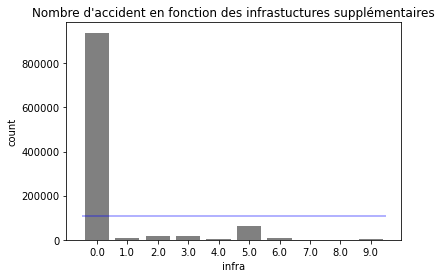

In [95]:
sns.countplot(x=dfLieux.infra[(dfLieux.infra>-1)], color='grey')
plt.title("Nombre d'accident en fonction des infrastuctures supplémentaires")
plt.hlines(y=len(dfLieux['infra'][(dfLieux.infra>-1)])/10, xmin=-0.5, xmax=9.5, color='blue', alpha=0.4);
# Many accidents when there are no additional infrastructures

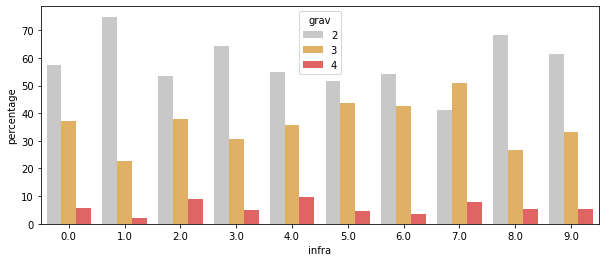

In [44]:
# Initiating dataframe grouped
dfCaracGpByInfra = (dfLieux[(dfLieux.infra>-1)].groupby(['infra'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="infra", y="percentage", hue="grav", data=dfCaracGpByInfra, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\148533536.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


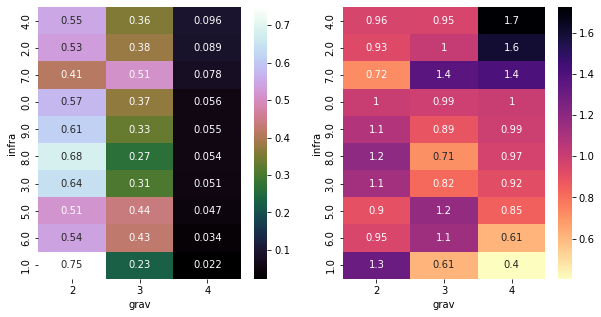

In [104]:
# data-management
dfInfraGrav = pd.crosstab(dfLieux['infra'][(dfLieux['infra']!=-1)], dfLieux['grav'][(dfLieux['infra']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfInfraGravRaw = pd.crosstab(dfLieux['infra'][(dfLieux['infra']!=-1)], dfLieux['grav'][(dfLieux['infra']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfInfraGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfInfraGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['infra']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### situ

In [78]:
#cat
dfLieux.situ[(dfLieux.situ>-1)].value_counts()

1.0    890976
3.0     84281
0.0     47458
4.0     18058
2.0      7711
5.0      7594
8.0      2817
6.0      1061
Name: situ, dtype: int64

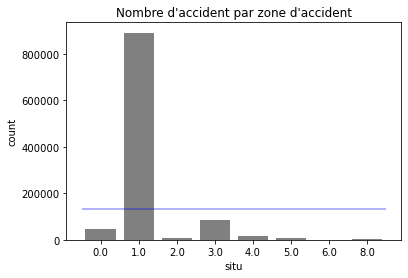

In [98]:
sns.countplot(x=dfLieux.situ[(dfLieux.situ>-1)], color='grey')
plt.title("Nombre d'accident par zone d'accident")
plt.hlines(y=len(dfLieux['situ'][(dfLieux.situ>-1)])/8, xmin=-0.5, xmax=7.5, color='blue', alpha=0.4);
# Many accidents happen on the road

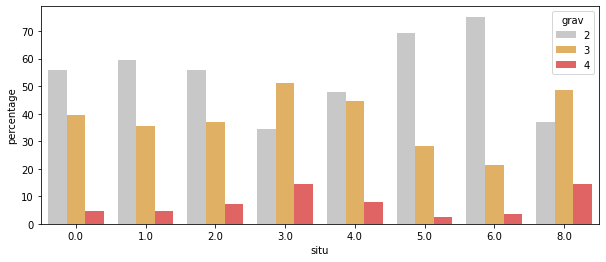

In [45]:
# Initiating dataframe grouped
dfCaracGpBySitu = (dfLieux[(dfLieux.situ>-1)].groupby(['situ'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="situ", y="percentage", hue="grav", data=dfCaracGpBySitu, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\2957550094.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


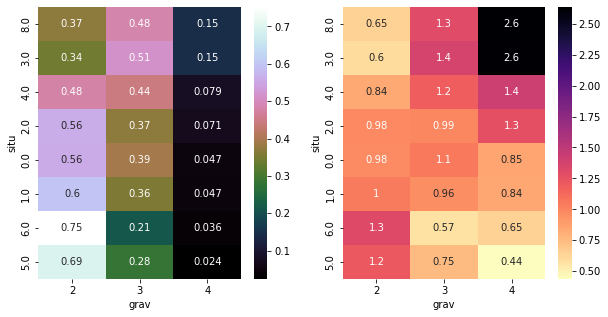

In [105]:
# data-management
dfSituGrav = pd.crosstab(dfLieux['situ'][(dfLieux['situ']!=-1)], dfLieux['grav'][(dfLieux['situ']!=-1)], normalize=0).sort_values(by=4, ascending=False)
dfSituGravRaw = pd.crosstab(dfLieux['situ'][(dfLieux['situ']!=-1)], dfLieux['grav'][(dfLieux['situ']!=-1)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfSituGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfSituGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['situ']!=-1)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

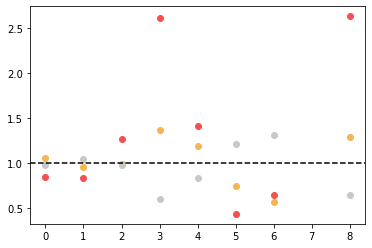

In [48]:
plt.plot(dfSituGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['situ']!=-1)].value_counts(normalize=True), axis=1)[4], 'o', color='#F45050')
plt.plot(dfSituGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['situ']!=-1)].value_counts(normalize=True), axis=1)[3], 'o', color='#F4B650')
plt.plot(dfSituGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['situ']!=-1)].value_counts(normalize=True), axis=1)[2], 'o', color='#C8C8C8')
plt.axhline(y=1, color='k', linestyle='--');

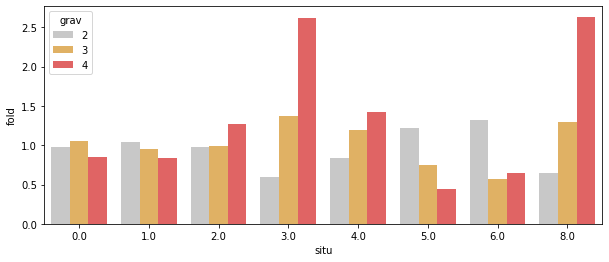

In [49]:
# Data-management
dfSituGravFold = dfSituGrav.apply(lambda x: x/dfLieux['grav'][(dfLieux['situ']!=-1)].value_counts(normalize=True), axis=1).stack().reset_index()

# Rename columns
dfSituGravFold.rename(columns={'level_1':'grav', 0:'fold'}, inplace=True)

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='situ', y='fold', hue='grav', data=dfSituGravFold, 
             palette=['#C8C8C8','#F4B650','#F45050']);

### env1

In [79]:
#cat
dfLieux.env1.value_counts()

0.0     541532
99.0    366673
3.0      44824
Name: env1, dtype: int64

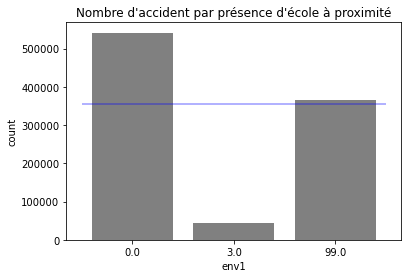

In [101]:
sns.countplot(x=dfLieux.env1, color='grey')
plt.title("Nombre d'accident par présence d'école à proximité")
plt.hlines(y=len(dfLieux['env1'])/3, xmin=-0.5, xmax=2.5, color='blue', alpha=0.4);
# Many accidents happen when there are no school near

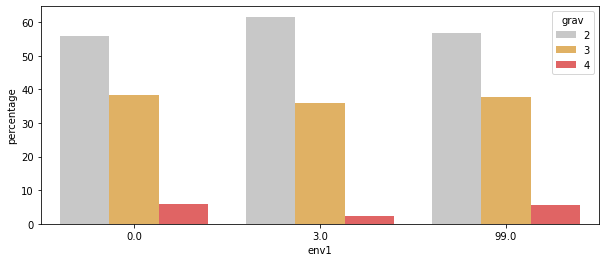

In [50]:
# Initiating dataframe grouped
dfCaracGpByEnv1 = (dfLieux.groupby(['env1'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="env1", y="percentage", hue="grav", data=dfCaracGpByEnv1, 
             palette=['#C8C8C8','#F4B650','#F45050']);
# XXX

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\3981267180.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


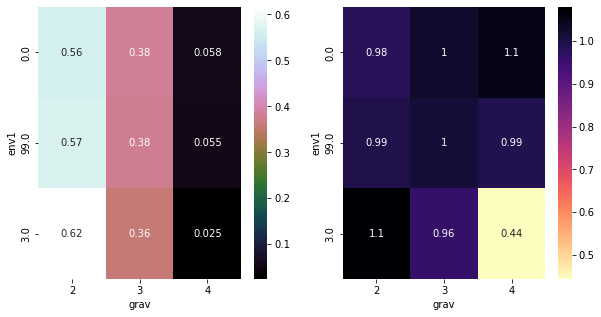

In [106]:
# data-management
dfEnv1Grav = pd.crosstab(dfLieux['env1'], dfLieux['grav'], normalize=0).sort_values(by=4, ascending=False)
dfEnv1GravRaw = pd.crosstab(dfLieux['env1'], dfLieux['grav']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfEnv1Grav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfEnv1Grav.apply(lambda x: x/dfLieux['grav'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### catu

In [53]:
dfUsagers.grav.value_counts(normalize=True)

1    0.409152
4    0.361345
3    0.202676
2    0.026826
Name: grav, dtype: float64

In [18]:
dfUsagers.catu.value_counts(normalize=True)

1    0.743463
2    0.172022
3    0.083020
4    0.001496
Name: catu, dtype: float64

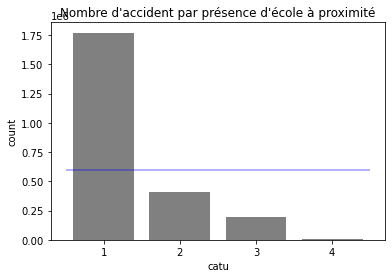

In [50]:
sns.countplot(x=dfUsagers.catu, color='grey')
plt.title("Nombre d'accident par présence d'école à proximité")
plt.hlines(y=len(dfUsagers['catu'])/4, xmin=-0.5, xmax=3.5, color='blue', alpha=0.4);
# XXX

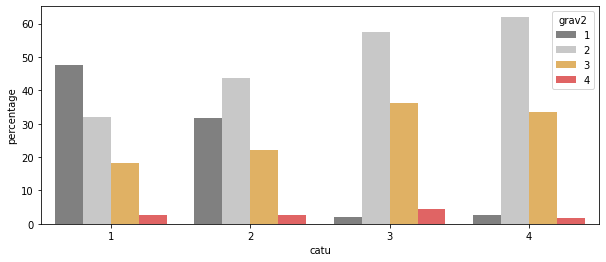

In [39]:
# Initiating dataframe grouped
dfUsagersGpByCatu = (dfUsagers.groupby(['catu'])['grav2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav2'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="catu", y="percentage", hue="grav2", data=dfUsagersGpByCatu, 
             palette=['grey', '#C8C8C8', '#F4B650', '#F45050']);
# Les piétons semblent avoir plus d'hospitalisations
# Les piétons pedestres semblent avoir plus d'accidents de gravité 4

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\324126077.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


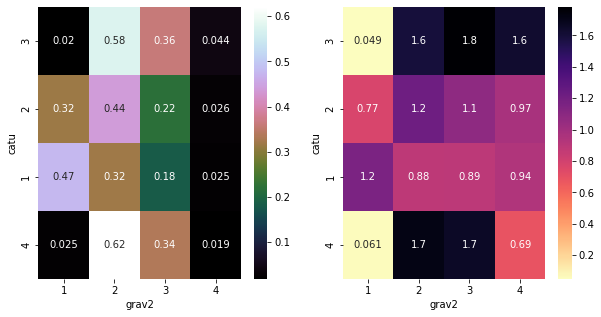

In [107]:
# data-management
dfCatuGrav = pd.crosstab(dfUsagers['catu'], dfUsagers['grav2'], normalize=0).sort_values(by=4, ascending=False)
dfCatuGravRaw = pd.crosstab(dfUsagers['catu'], dfUsagers['grav2']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfCatuGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfCatuGrav.apply(lambda x: x/dfUsagers['grav2'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### grav

In [17]:
dfUsagers.grav.value_counts(normalize=True)

1    0.409152
4    0.361345
3    0.202676
2    0.026826
Name: grav, dtype: float64

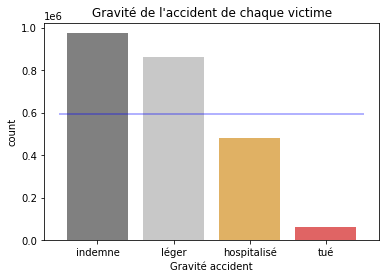

In [31]:
sns.countplot(x=dfUsagers.grav2, palette=['grey', '#C8C8C8', '#F4B650', '#F45050'])
plt.title("Gravité de l'accident de chaque victime")
plt.hlines(y=len(dfUsagers['grav'])/4, xmin=-0.5, xmax=3.5, color='blue', alpha=0.4)
plt.xticks(ticks=np.arange(0, 4, 1), labels=['indemne', 'léger', 'hospitalisé', 'tué'])
plt.xlabel('Gravité accident');
# Cette variable devrait être présentée

### sexe

In [16]:
dfUsagers.sexe.value_counts(normalize=True)

1    0.673044
2    0.326956
Name: sexe, dtype: float64

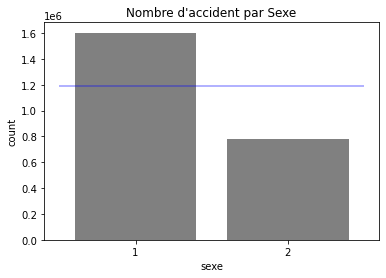

In [158]:
sns.countplot(x=dfUsagers.sexe, color='grey')
plt.title("Nombre d'accident par Sexe")
plt.hlines(y=len(dfUsagers['sexe'])/2, xmin=-0.5, xmax=1.5, color='blue', alpha=0.4);
# XXX

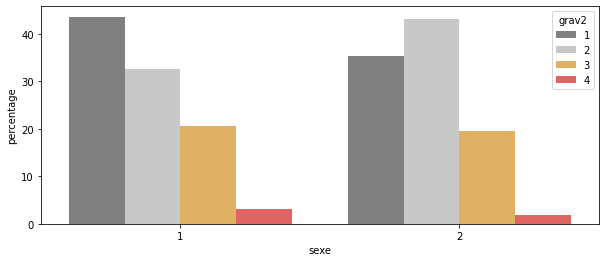

In [34]:
# Initiating dataframe grouped
dfUsagersGpBySexe = (dfUsagers.groupby(['sexe'])['grav2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav2'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="sexe", y="percentage", hue="grav2", data=dfUsagersGpBySexe, 
             palette=['grey', '#C8C8C8', '#F4B650', '#F45050']);
# Plus de tués chez les hommes mais plus de blessés indemnes également, paradoxalement

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\4054749710.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


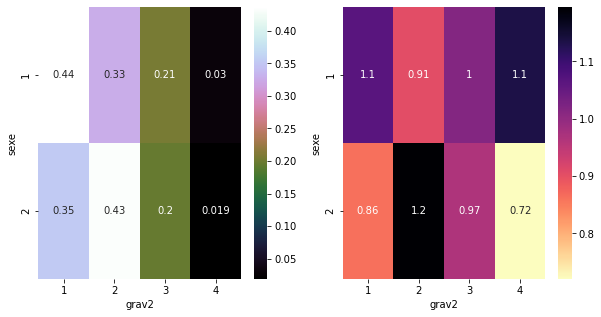

In [108]:
# data-management
dfSexeGrav = pd.crosstab(dfUsagers['sexe'], dfUsagers['grav2'], normalize=0).sort_values(by=4, ascending=False)
dfSexeGravRaw = pd.crosstab(dfUsagers['sexe'], dfUsagers['grav2']).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfSexeGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfSexeGrav.apply(lambda x: x/dfUsagers['grav2'].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### trajet

In [19]:
dfUsagers.trajet.value_counts(normalize=True)

 5.0    0.372569
 0.0    0.281276
 1.0    0.130794
 4.0    0.097458
 9.0    0.070523
 3.0    0.026385
 2.0    0.020678
-1.0    0.000318
Name: trajet, dtype: float64

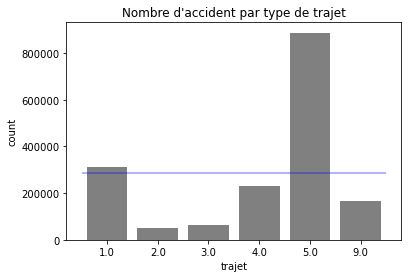

In [24]:
sns.countplot(x=dfUsagers.trajet[(dfUsagers.trajet>0)], color='grey')
plt.title("Nombre d'accident par type de trajet")
plt.hlines(y=len(dfUsagers['trajet'][(dfUsagers.trajet>0)])/6, xmin=-0.5, xmax=5.5, color='blue', alpha=0.4);
# XXX

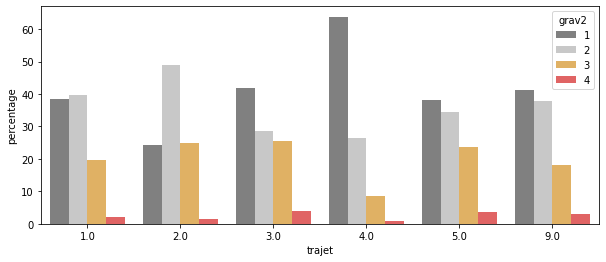

In [47]:
# Initiating dataframe grouped
dfUsagersGpByTrajet = (dfUsagers[(dfUsagers.trajet>0)].groupby(['trajet'])['grav2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav2'))

# Display plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="trajet", y="percentage", hue="grav2", data=dfUsagersGpByTrajet, 
             palette=['grey', '#C8C8C8', '#F4B650', '#F45050']);
# Plus de tués chez les hommes mais plus de blessés indemnes également, paradoxalement

C:\Users\Megaport\AppData\Local\Temp\ipykernel_12688\130632220.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


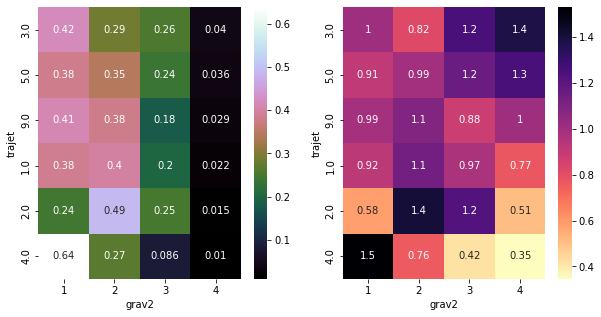

In [109]:
# data-management
dfTrajetGrav = pd.crosstab(dfUsagers['trajet'][(dfUsagers.trajet>0)], dfUsagers['grav2'][(dfUsagers.trajet>0)], normalize=0).sort_values(by=4, ascending=False)
dfTrajetGravRaw = pd.crosstab(dfUsagers['trajet'][(dfUsagers.trajet>0)], dfUsagers['grav2'][(dfUsagers.trajet>0)]).sort_values(by=4, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfTrajetGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfTrajetGrav.apply(lambda x: x/dfUsagers['grav2'][(dfUsagers.trajet>0)].value_counts(normalize=True), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# XXX

### Inferential analysis

1    0.41
2    0.36
3    0.20
4    0.03
Name: grav2, dtype: float64
2    0.57
3    0.37
4    0.06
Name: grav, dtype: float64


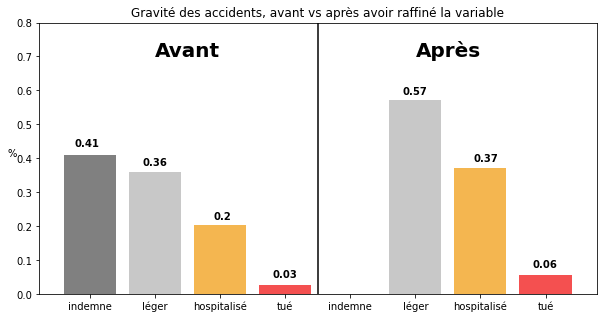

In [10]:
# Proportions
propUsagersGrav = round(dfUsagers.grav2.value_counts(normalize=True), 2)
propCaracGrav = round(dfCarac.grav.value_counts(normalize=True), 2)
print(propUsagersGrav)
print(propCaracGrav)

# Display plot
plt.figure(figsize=(10, 5))
    # plot
plt.bar([1, 2, 3, 4], dfUsagers.grav2.value_counts(normalize=True), label='Exemple 1', color=['grey', '#C8C8C8', '#F4B650', '#F45050'])
plt.bar([6, 7, 8], dfCarac.grav.value_counts(normalize=True), label='Exemple 2', color=['#C8C8C8', '#F4B650', '#F45050'])
plt.plot([4.5, 4.5], [0, 0.8], color='k')
    # text around the plot
plt.ylim([0, 0.8])
plt.xticks(ticks=np.arange(1, 9, 1), labels=['indemne', 'léger', 'hospitalisé', 'tué', 'indemne', 'léger', 'hospitalisé', 'tué'])
plt.title('Gravité des accidents, avant vs après avoir raffiné la variable')
plt.ylabel('%', rotation=0)
    # text inside the plot
plt.text(2, 0.7, 'Avant', weight='bold', fontsize=20)
plt.text(6, 0.7, 'Après', weight='bold', fontsize=20)
plt.text(0.75, propUsagersGrav.loc[1]+0.025, propUsagersGrav.loc[1], weight='bold')
for i in np.arange(2, 5):
    plt.text([1.8, 2.9, 3.8][i-2], propUsagersGrav.loc[i]+0.02, propUsagersGrav.loc[i], weight='bold')
    plt.text([5.8, 6.9, 7.8][i-2], propCaracGrav.loc[i]+0.02, propCaracGrav.loc[i], weight='bold');

In [102]:
### V Cramer score & p-value
# Function
def vCramerChisqPvalue(varname, var, contingtableRaw):
    res = varname, round(V_cramer(contingtableRaw, len(var)), 2), round(chi2_contingency(contingtableRaw)[1], 4)
    return res

# Filling table
dfVcramerChisqPvalue = pd.DataFrame([vCramerChisqPvalue('year', dfCarac['year'], dfYearGravRaw), 
              vCramerChisqPvalue('mois', dfCarac['mois'], dfMonthGravRaw), 
              vCramerChisqPvalue('jour', dfCarac['jour'], dfMonthdayGravRaw), 
              vCramerChisqPvalue('weekday', dfCarac['weekday'], dfWeekdayGravRaw), 
              vCramerChisqPvalue('hour', dfCarac['hour'], dfHourGravRaw), 
              vCramerChisqPvalue('lum', dfCarac['lum'], dfLumGravRaw), 
              vCramerChisqPvalue('atm', dfCarac['atm'], dfAtmGravRaw), 
              vCramerChisqPvalue('col', dfCarac['col'], dfColGravRaw), 
              vCramerChisqPvalue('agg', dfCarac['agg'], dfAggGravRaw), 
              vCramerChisqPvalue('nbv', dfLieux['nbv'], dfNbvGravRaw), 
              vCramerChisqPvalue('vosp', dfLieux['vosp'], dfVospGravRaw), 
              vCramerChisqPvalue('prof', dfLieux['prof'], dfProfGravRaw), 
              vCramerChisqPvalue('plan', dfLieux['plan'], dfPlanGravRaw), 
              vCramerChisqPvalue('surf', dfLieux['surf'], dfSurfGravRaw), 
              vCramerChisqPvalue('infra', dfLieux['infra'], dfInfraGravRaw), 
              vCramerChisqPvalue('situ', dfLieux['situ'], dfSituGravRaw), 
              vCramerChisqPvalue('env1', dfLieux['env1'], dfEnv1GravRaw), 
              vCramerChisqPvalue('catu', dfUsagers['catu'], dfCatuGravRaw), 
              vCramerChisqPvalue('sexe', dfUsagers['sexe'], dfSexeGravRaw), 
              vCramerChisqPvalue('trajet', dfUsagers['trajet'], dfTrajetGravRaw)])
dfVcramerChisqPvalue = dfVcramerChisqPvalue.rename({0:'Variable', 1:'V Cramer', 2:'pvalue'}, axis=1)

# Display table
dfVcramerChisqPvalue.sort_values(by='V Cramer', ascending=False)
# dfVcramerChisqPvalue

,Variable,V Cramer,pvalue
8,agg,0.29,0.0
17,catu,0.16,0.0
7,col,0.16,0.0
9,nbv,0.14,0.0
5,lum,0.13,0.0
15,situ,0.12,0.0
18,sexe,0.11,0.0
12,plan,0.11,0.0
19,trajet,0.10,0.0
11,prof,0.08,0.0


In [13]:
##### Vcramer between variables
### Initiating objects
varList1Carac = ['year', 'mois', 'jour', 'weekday', 'hour', 'lum', 'atm', 'col', 'agg', 'int']
varList2Carac = ['year', 'mois', 'jour', 'weekday', 'hour', 'lum', 'atm', 'col', 'agg', 'int']
varList1Lieux = ['catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'env1']
varList2Lieux = ['catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'env1']
varList1Usagers = ['place', 'catu', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp']
varList2Usagers = ['place', 'catu', 'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp']
varList1Vehicules = ['choc', 'manv', 'motor', 'senc', 'catv', 'obs', 'obsm']
varList2Vehicules = ['choc', 'manv', 'motor', 'senc', 'catv', 'obs', 'obsm']
resMatrixCarac = pd.DataFrame(np.zeros(shape=(len(varList1Carac), len(varList2Carac))), index=varList1Carac, columns=varList2Carac)
resMatrixLieux = pd.DataFrame(np.zeros(shape=(len(varList1Lieux), len(varList2Lieux))), index=varList1Lieux, columns=varList2Lieux)
resMatrixUsagers = pd.DataFrame(np.zeros(shape=(len(varList1Usagers), len(varList2Usagers))), index=varList1Usagers, columns=varList2Usagers)
resMatrixVehicules = pd.DataFrame(np.zeros(shape=(len(varList1Vehicules), len(varList2Vehicules))), index=varList1Vehicules, columns=varList2Vehicules)

### Filling dataframe (Carac)
for i in varList1Carac:
    for j in varList2Carac:
        tab = pd.crosstab(dfCarac[i], dfCarac[j])
        resMatrixCarac[j][i] = round(V_cramer(tab, tab.sum().sum()), 2)
### Filling dataframe (Lieux)
for i in varList1Lieux:
    for j in varList2Lieux:
        tab = pd.crosstab(dfLieux[i], dfLieux[j])
        resMatrixLieux[j][i] = round(V_cramer(tab, tab.sum().sum()), 2)
### Filling dataframe (Usagers)
for i in varList1Usagers:
    for j in varList2Usagers:
        tab = pd.crosstab(dfUsagers[i], dfUsagers[j])
        resMatrixUsagers[j][i] = round(V_cramer(tab, tab.sum().sum()), 2)
### Filling dataframe (Vehicules)
for i in varList1Vehicules:
    for j in varList2Vehicules:
        tab = pd.crosstab(dfVehicules[i], dfVehicules[j])
        resMatrixVehicules[j][i] = round(V_cramer(tab, tab.sum().sum()), 2)

         year  mois  jour  weekday  hour   lum   atm   col   agg   int
year     1.00  0.02  0.01     0.01  0.01  0.02  0.03  0.07  0.05  0.04
mois     0.02  1.00  0.05     0.01  0.03  0.12  0.08  0.02  0.04  0.01
jour     0.01  0.05  1.00     0.03  0.01  0.01  0.01  0.00  0.01  0.00
weekday  0.01  0.01  0.03     1.00  0.06  0.03  0.01  0.02  0.05  0.01
hour     0.01  0.03  0.01     0.06  1.00  0.38  0.05  0.06  0.09  0.02
lum      0.02  0.12  0.01     0.03  0.38  1.00  0.29  0.07  0.37  0.07
atm      0.03  0.08  0.01     0.01  0.05  0.29  1.00  0.03  0.09  0.02
col      0.07  0.02  0.00     0.02  0.06  0.07  0.03  1.00  0.25  0.14
agg      0.05  0.04  0.01     0.05  0.09  0.37  0.09  0.25  1.00  0.27
int      0.04  0.01  0.00     0.01  0.02  0.07  0.02  0.14  0.27  1.00
       catr  circ   nbv  vosp  prof  plan  surf  infra  situ  env1
catr   1.00  0.27  0.19  0.06  0.06  0.10  0.04   0.10  0.10  0.09
circ   0.27  1.00  0.32  0.03  0.08  0.11  0.08   0.10  0.12  0.06
nbv    0.19  0.32 

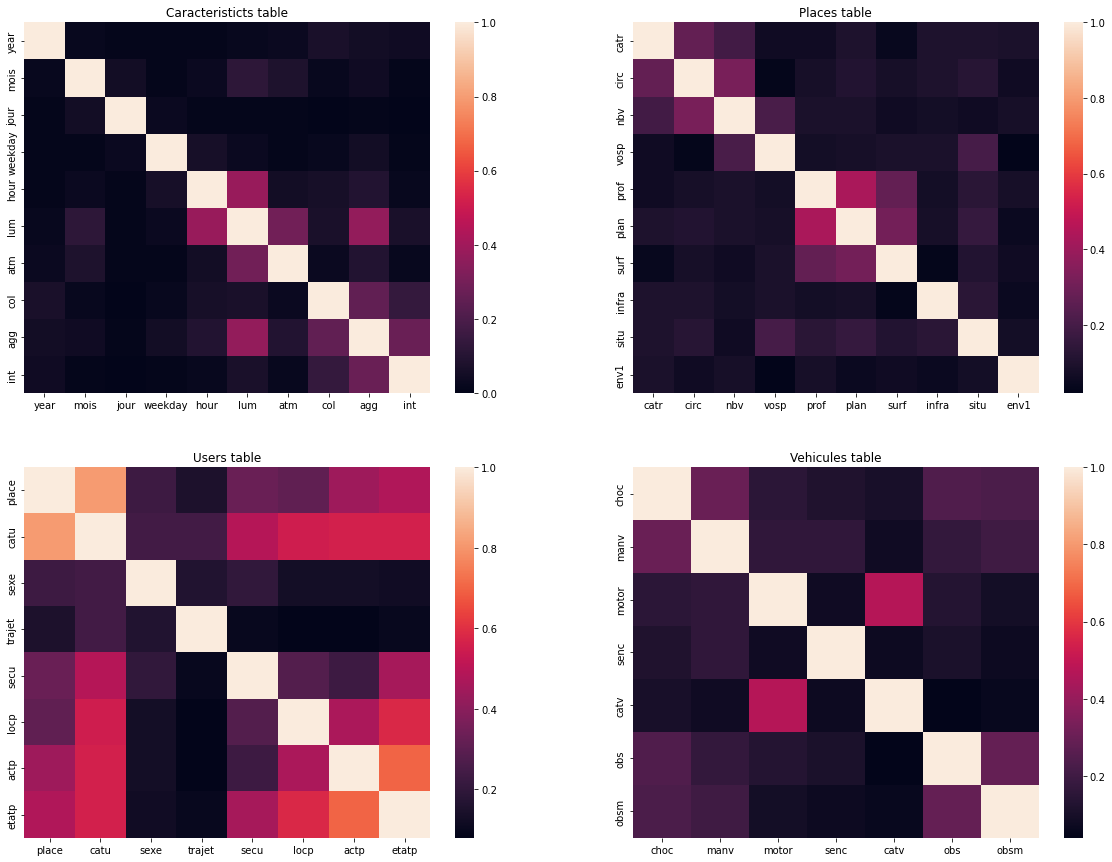

In [24]:
# Display VCramer dataframes - Unique datasets
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.heatmap(resMatrixCarac, ax=ax[0, 0])
ax[0, 0].set_title('Caracteristicts table')
sns.heatmap(resMatrixLieux, ax=ax[0, 1])
ax[0, 1].set_title('Places table')
sns.heatmap(resMatrixUsagers, ax=ax[1, 0])
ax[1, 0].set_title('Users table');
sns.heatmap(resMatrixVehicules, ax=ax[1, 1])
ax[1, 1].set_title('Vehicules table');

# Display raw VCramer dataframes
print(resMatrixCarac)
print(resMatrixLieux)
print(resMatrixUsagers)
print(resMatrixVehicules)

In [5]:
##### Describing dfPool
dfPool.head(2)

,Unnamed: 0,Num_Acc,catr,circ,prof,surf,infra,situ,env1,grav_x,...,catv_train_exist,catv_PL_exist,catv_2_roues_exist,catv_EPD_exist,num_veh,obsGrp,population_tot,populationGrp,intGrp,choc_cote
0,0,201600000001,3.0,2.0,1.0,1.0,0.0,1.0,0.0,3,...,0,0,1,0,2,Pas d'Obstacle,3515.0,Bourg,Hors intersection,1
1,1,201600000002,3.0,1.0,1.0,1.0,0.0,1.0,0.0,3,...,0,0,0,0,1,Obstacle,3515.0,Bourg,Croisement circulaire,2


In [6]:
dfPool.apply(pd.Series.value_counts)

,Unnamed: 0,Num_Acc,catr,circ,prof,surf,infra,situ,env1,grav_x,...,catv_train_exist,catv_PL_exist,catv_2_roues_exist,catv_EPD_exist,num_veh,obsGrp,population_tot,populationGrp,intGrp,choc_cote
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,1.0,NaN,NaN,NaN,NaN,NaN,938199.0,NaN,541532.0,NaN,...,1064624.0,991057.0,587199.0,1063228.0,NaN,NaN,5.0,NaN,NaN,142715.0
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6666666666666666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,1.0,NaN,82584.0,189260.0,813712.0,829791.0,9440.0,890976.0,NaN,NaN,...,429.0,73996.0,477854.0,1825.0,406883.0,NaN,NaN,NaN,NaN,461829.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
may,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nuit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dfPool[dfPool.eq(-1).any(1)]
# dfPool[dfPool.eq(-1).any(1)].iloc[:, 41: 50]

,Unnamed: 0,Num_Acc,catr,circ,prof,surf,infra,situ,env1,grav_x,...,catv_train_exist,catv_PL_exist,catv_2_roues_exist,catv_EPD_exist,num_veh,obsGrp,population_tot,populationGrp,intGrp,choc_cote
1037368,1037368,202000020060,7.0,2.0,1.0,2.0,0.0,1.0,NaN,2,...,0,0,1,0,2,Pas d'Obstacle,52669.0,Grande Ville,Autres,1


In [18]:
dfPool.columns

Index(['Unnamed: 0', 'Num_Acc', 'catr', 'circ', 'prof', 'surf', 'infra',
       'situ', 'env1', 'grav_x', 'nbvGrp', 'vospGrp', 'planGrp', 'lartpcGrp',
       'larroutGrp', 'mois', 'jour', 'lum', 'agg', 'int', 'atm', 'col', 'com',
       'dep', 'grav_y', 'date', 'mois_label', 'weekday', 'hour', 'year',
       'hourGrp', 'dateFerie', 'dateWeekend', 'dateFerieAndWeekend',
       'gravGrp_23_4', 'gravGrp_2_34', 'catu_pieton', 'sexe_male_conductor',
       'sexe_female_conductor', 'trajet_coursesPromenade_conductor',
       'nb_grav4_by_acc', 'nb_grav3_by_acc', 'nb_catu_pieton',
       'nb_sexe_male_conductor', 'nb_sexe_female_conductor',
       'nb_trajet_coursesPromenade_conductor', 'nb_etatpGrp_pieton_alone',
       'nb_locpGrp_pieton_1', 'nb_locpGrp_pieton_3', 'nb_locpGrp_pieton_6',
       'ageMeanConductors', 'ageMeanNonConductors', 'catv_train_exist',
       'catv_PL_exist', 'catv_2_roues_exist', 'catv_EPD_exist', 'num_veh',
       'obsGrp', 'population_tot', 'populationGrp', 'intGrp'

##### DataFrame with NA prevalence and p-value against gravGrp_2_34

In [9]:
a = dfPool.iloc[:,38]
print(len(a.unique()))
a.value_counts()

2


0    663797
1    401256
Name: sexe_female_conductor, dtype: int64

In [6]:
# Nouveau dataFrame sans NA
dfPoolCCA = dfPool.dropna()

# Verification du nombre de NA
print('NA count:', (dfPoolCCA.isnull().sum() * 100 / len(dfPoolCCA)).sum())
print('Dim:', dfPoolCCA.shape)

NA count: 0.0
Dim: (17410, 62)


In [7]:
# Création du dataFrame qui permettra de faire la sélection de variables
dfDescVarExpl = pd.DataFrame({'propNA':dfPool.isnull().sum() * 100 / len(dfPool), 
                              'lenUnique':dfPool.apply(lambda x: len(x.unique()), axis=0),
                              'type':['nonInf', 'nonInf', 'cat', 'cat', 'cat', 'cat', 
                                      'cat', 'cat', 'cat', 'target', 'cat', 'bin', 
                                      'bin', 'cat', 'cat', 'cat', 'nonInf', 'cat', 
                                      'bin', 'cat', 'cat', 'cat', 'nonInf', 'nonInf', 
                                      'target', 'nonInf', 'cat', 'cat', 'cat', 'nonInf', 
                                      'cat', 'bin', 'bin', 'bin', 'target', 'target', 
                                      'bin', 'bin', 'bin', 'bin', 'target', 'target', 
                                      'num', 'num', 'num', 'num', 'num', 'num', 
                                      'num', 'num', 'num', 'num', 'bin', 'bin', 
                                      'bin', 'bin', 'num', 'bin', 'num', 'cat', 
                                      'cat', 'num']})

In [12]:
# Création de la variable p-value
dfDescVarExpl['pvalue'] = np.nan

In [13]:
### loop p-values over all variables
for i in dfDescVarExpl.index:
    varCateg = dfPoolCCA[i]
    if dfDescVarExpl.type.loc[i] in ['bin', 'cat']:
        table = pd.crosstab(dfPoolCCA['gravGrp_2_34'], varCateg)
        dfDescVarExpl.pvalue.loc[i] = chi2_contingency(table)[1:2][0]
    if dfDescVarExpl.type.loc[i] in ['num']:
        result = statsmodels.formula.api.ols(i + ' ~ gravGrp_2_34', data=dfPoolCCA).fit()
        dfDescVarExpl.pvalue.loc[i] = statsmodels.api.stats.anova_lm(result).loc['gravGrp_2_34'][4]

C:\Users\Megaport\AppData\Local\Temp\ipykernel_17732\1977395160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDescVarExpl.pvalue.loc[i] = chi2_contingency(table)[1:2][0]
C:\Users\Megaport\AppData\Local\Temp\ipykernel_17732\1977395160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDescVarExpl.pvalue.loc[i] = chi2_contingency(table)[1:2][0]
C:\Users\Megaport\AppData\Local\Temp\ipykernel_17732\1977395160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [14]:
dfDescVarExpl.sort_values('propNA', ascending=False).head(10)

,propNA,lenUnique,type,pvalue
lartpcGrp,93.476475,5,cat,2.574388e-70
ageMeanNonConductors,59.151047,1699,num,2.655378e-48
larroutGrp,43.833124,5,cat,1.071626e-43
env1,10.518162,4,cat,3.036175e-18
planGrp,6.451885,3,bin,1.976461e-02
prof,6.376584,5,cat,5.064228e-06
circ,5.382455,5,cat,7.919353e-63
population_tot,5.198145,5794,num,2.439999e-258
situ,4.934496,8,cat,1.018252e-87
surf,3.459546,9,cat,8.300374e-09


In [15]:
dfDescVarExpl.sort_values('lenUnique', ascending=False).head(10)

,propNA,lenUnique,type,pvalue
Unnamed: 0,0.000000,1065053,nonInf,NaN
Num_Acc,0.000000,1065053,nonInf,NaN
date,0.000000,5844,nonInf,NaN
population_tot,5.198145,5794,num,2.439999e-258
ageMeanNonConductors,59.151047,1699,num,2.655378e-48
com,0.094080,925,nonInf,NaN
ageMeanConductors,1.574663,920,num,2.057691e-20
dep,0.000000,197,nonInf,NaN
choc_cote,0.000000,35,num,8.519385e-19
jour,0.000000,31,nonInf,NaN


In [ ]:
# Create a dataframe specific for ML dfPoolML where variables that can't be used won't be there
# Create a new dataframe
# Create xl file with quick definition of each variables that can be used for ML: what is it, categories, type (cat/num), corr
# Il reste des données -1 (e.g. int)

In [92]:
dfDescVarExpl[dfDescVarExpl.type=='num'].index

Index(['nb_catu_pieton', 'nb_sexe_male_conductor', 'nb_sexe_female_conductor',
       'nb_trajet_coursesPromenade_conductor', 'nb_etatpGrp_pieton_alone',
       'nb_locpGrp_pieton_1', 'nb_locpGrp_pieton_3', 'nb_locpGrp_pieton_6',
       'ageMeanConductors', 'ageMeanNonConductors', 'num_veh',
       'population_tot', 'choc_cote'],
      dtype='object')

In [147]:
dfDescVarExpl.loc[['num_veh', 'obsGrp', 'col']]

,propNA,lenUnique,type,pvalue
num_veh,0.000000,28,num,1.597770e-38
obsGrp,0.005727,3,bin,6.421705e-49
col,0.144218,8,cat,3.023334e-125


In [142]:
dfPool['com'].value_counts()

55.0     39032
88.0     15952
7.0      14373
63.0     12422
113.0    10987
         ...  
952.0        1
925.0        1
892.0        1
878.0        1
847.0        1
Name: com, Length: 924, dtype: int64

In [6]:
### Adding missing variables
dfPool['etatpGrp_pieton_alone'] = np.where(dfPool.groupby('Num_Acc')['nb_etatpGrp_pieton_alone'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_1'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_1'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_3'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_3'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_6'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_6'].sum()>=1, 1, 0)

In [18]:
##### Vcramer between variables - pooled dataset
### Initiating objects
# varList1Pool = ['prof', 'planGrp', 'surf', 'atm', 'situ', 
#                 'vospGrp', 
#                 'larroutGrp', 'lartpcGrp', 
#                 'env1', 'catv_EPD_exist', 'catv_PL_exist', 
#                 'obsGrp', 'trajet_coursesPromenade_conductor', 
#                 'sexe_male_conductor', 'sexe_female_conductor', 
#                 'int', 'intGrp', 'catv_train_exist', 'infra', 'agg', 'catr', 'hour', 'hourGrp', 'lum', 'com', 'dep', 'circ', 'nbvGrp', 
#                 'catv_2_roues_exist', 'nbVeh', 'catu_pieton', 'col', 'populationGrp', 
#                 'year', 'mois_label', 'jour', 
#                 'weekday', 'dateWeekend', 'dateFerieAndWeekend', 'dateFerie']

# Id: 'Num_Acc', 
# Outcome: 'gravGrp_23_4', 'gravGrp_2_34', 'nb_grav4_by_acc', 'nb_grav3_by_acc', 

# Removed (nonInformative): 'Unnamed: 0', 'date', 'dep', 'jour', 'grav_x', 'grav_y', 'year', 'mois', 'com', 
# Removed (tooManyNA): 'lartpcGrp', 'ageMeanNonConductors', 'larroutGrp', 'env1', 
# Removed (correlated): 'int', 'agg', 'catu_pieton', 'weekday', 'dateWeekend', 

# Numeric removed (correlated): 'nb_sexe_male_conductor', 'nb_sexe_female_conductor', 'nb_catu_pieton', 
#'hour', 'population_tot', 'nb_trajet_coursesPromenade_conductor', 
#'nb_etatpGrp_pieton_alone', 'nb_locpGrp_pieton_1', 'nb_locpGrp_pieton_3', 'nb_locpGrp_pieton_6', 

# Numeric kept: , 'choc_cote', 'ageMeanConductors', 'num_veh', 
# Categorical kept:
#                 'prof', 'planGrp', 'surf', 'atm', 
#                 'vospGrp', 
#                 'catv_EPD_exist', 'catv_PL_exist', 
#                 'trajet_coursesPromenade_conductor',
#                 'sexe_male_conductor', 'sexe_female_conductor', 
#                 'intGrp', 'catv_train_exist', 'infra', 'catr', 'hourGrp', 'lum', 'circ', 'nbvGrp', 
#                 'catv_2_roues_exist', 'col', 'obsGrp', 'situ', 'populationGrp', 
#                 'mois_label', 'dateFerieAndWeekend', 'dateFerie',
#                 'etatpGrp_pieton_alone', 'locpGrp_pieton_1', 'locpGrp_pieton_3', 'locpGrp_pieton_6'

varList1Pool = ['prof', 'planGrp', 'surf', 'atm', 
                'vospGrp', 
                'catv_EPD_exist', 'catv_PL_exist', 
                'trajet_coursesPromenade_conductor',
                'sexe_male_conductor', 'sexe_female_conductor', 
                'intGrp', 'catv_train_exist', 'infra', 'catr', 'hourGrp', 'lum', 'circ', 'nbvGrp', 
                'catv_2_roues_exist', 'col', 'obsGrp', 'situ', 'populationGrp', 
                'mois_label', 'dateFerieAndWeekend', 'dateFerie',
                'etatpGrp_pieton_alone', 'locpGrp_pieton_1', 'locpGrp_pieton_3', 'locpGrp_pieton_6'
                ]
varList2Pool = varList1Pool
resMatrixPool = pd.DataFrame(np.zeros(shape=(len(varList1Pool), len(varList2Pool))), index=varList1Pool, columns=varList2Pool)

### Filling dataframe (Pool)
for i in varList1Pool:
    for j in varList2Pool:
        tab = pd.crosstab(dfPool[i], dfPool[j])
        resMatrixPool[j][i] = round(V_cramer(tab, tab.sum().sum()), 2)

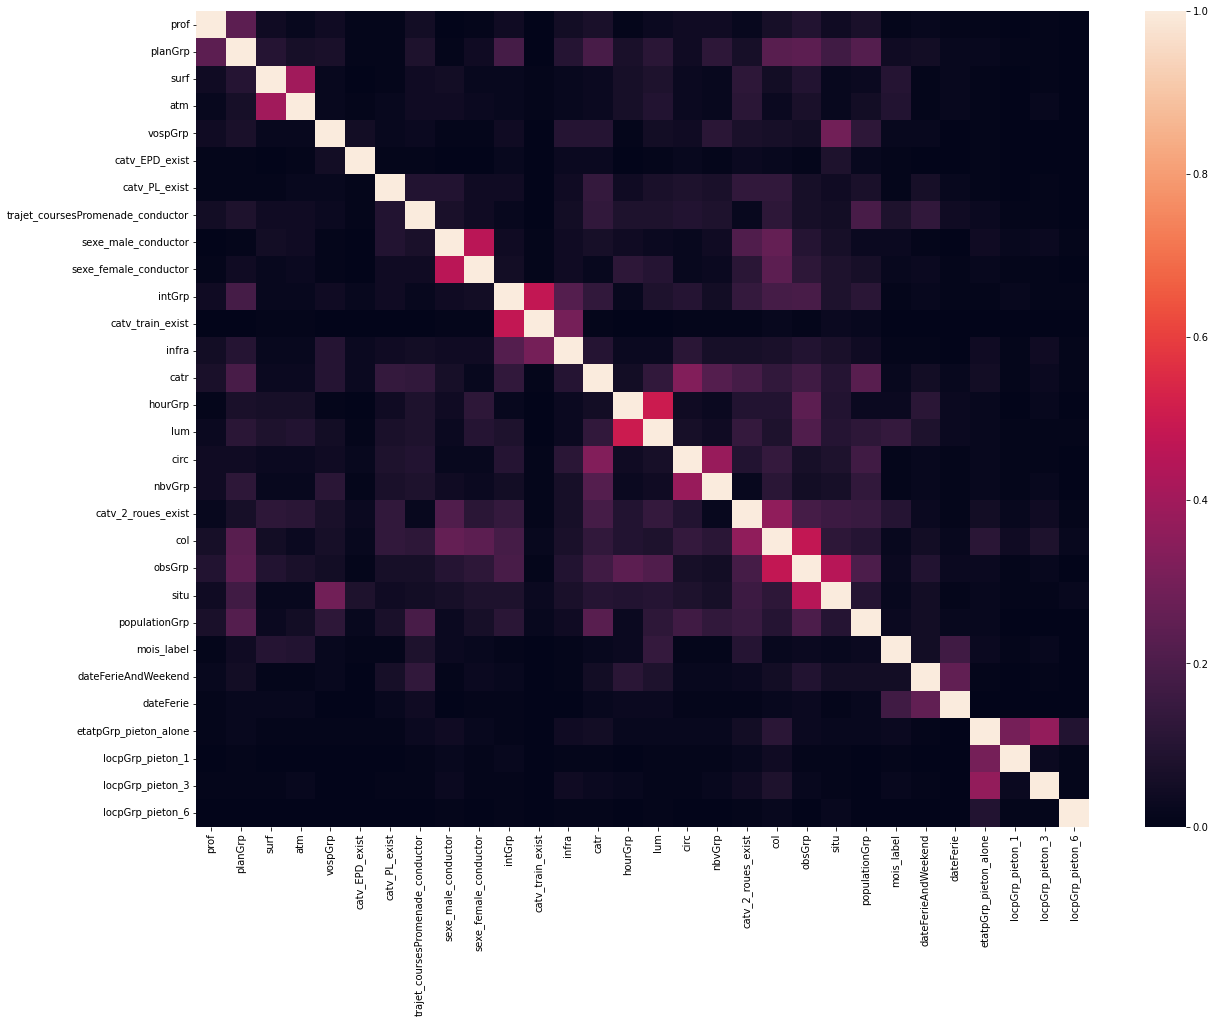

In [19]:
# Display VCramer dataframes
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(resMatrixPool, ax=ax);

In [7]:
##### Uptdates before export
### Removing -1 values
dfPool = dfPool.replace(-1, np.nan)

In [6]:
### Adding missing variables
dfPool['etatpGrp_pieton_alone'] = np.where(dfPool.groupby('Num_Acc')['nb_etatpGrp_pieton_alone'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_1'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_1'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_3'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_3'].sum()>=1, 1, 0)
dfPool['locpGrp_pieton_6'] = np.where(dfPool.groupby('Num_Acc')['nb_locpGrp_pieton_6'].sum()>=1, 1, 0)

In [8]:
### Modifying variables type
dfPool[['gravGrp_2_34', 'etatpGrp_pieton_alone', 'prof', 'circ', 'planGrp', 'surf', 'atm', 'vospGrp', 'catv_EPD_exist',
        'catv_PL_exist', 
        'trajet_coursesPromenade_conductor', 'sexe_male_conductor', 'sexe_female_conductor', 'catv_train_exist',
        'infra', 'catr', 'lum', 'catv_2_roues_exist', 'col', 'situ', 'dateFerieAndWeekend', 'dateFerie',
        'locpGrp_pieton_1', 'locpGrp_pieton_3', 'locpGrp_pieton_6']] = dfPool[['gravGrp_2_34', 'etatpGrp_pieton_alone', 
        'prof', 'circ', 'planGrp', 'surf', 'atm', 'vospGrp', 'catv_EPD_exist', 
        'catv_PL_exist', 
        'trajet_coursesPromenade_conductor', 'sexe_male_conductor', 'sexe_female_conductor', 'catv_train_exist',
        'infra', 'catr', 'lum', 'catv_2_roues_exist', 'col', 'situ', 'dateFerieAndWeekend', 'dateFerie',
        'locpGrp_pieton_1', 'locpGrp_pieton_3', 'locpGrp_pieton_6']].astype(object)

In [9]:
### Renaming variables
dfPool = dfPool.rename(columns={'num_veh': 'nbVeh'})

In [10]:
### Modifying index
dfPool = dfPool.set_index('Num_Acc')

In [11]:
##### DataFrame for ML
### Variables selection
dfPoolML = dfPool[[
                        # Variable à expliquer
                    'gravGrp_2_34', 
    
                        # Variables explicatives
                    'choc_cote', 'ageMeanConductors', 'nbVeh', 
                    'prof', 'planGrp', 'surf', 'atm', 
                    'vospGrp', 
                    'catv_EPD_exist', 'catv_PL_exist', 
                    'trajet_coursesPromenade_conductor',
                    'sexe_male_conductor', 'sexe_female_conductor', 
                    'intGrp', 'catv_train_exist', 'infra', 'catr', 'hourGrp', 'lum', 'circ', 'nbvGrp', 
                    'catv_2_roues_exist', 'col', 'obsGrp', 'situ', 'populationGrp', 
                    'mois_label', 'dateFerieAndWeekend', 'dateFerie',
                    'etatpGrp_pieton_alone', 'locpGrp_pieton_1', 'locpGrp_pieton_3', 'locpGrp_pieton_6']]

### Removing NA values
dfPoolMLCCA = dfPoolML.dropna()

In [102]:
##### Export dataframe
pathExport = 'D:\\jupyterDatasets\\'
dfPoolMLCCA.to_csv(pathExport+'20221031_table_dfPoolMLCCA.csv', index=False, sep=';')

In [12]:
dfPoolMLCCA.dtypes

gravGrp_2_34                          object
choc_cote                              int64
ageMeanConductors                    float64
nbVeh                                  int64
prof                                  object
planGrp                               object
surf                                  object
atm                                   object
vospGrp                               object
catv_EPD_exist                        object
catv_PL_exist                         object
trajet_coursesPromenade_conductor     object
sexe_male_conductor                   object
sexe_female_conductor                 object
intGrp                                object
catv_train_exist                      object
infra                                 object
catr                                  object
hourGrp                               object
lum                                   object
circ                                  object
nbvGrp                                object
catv_2_rou

In [13]:
dfPoolML.shape

(1065053, 34)

In [14]:
dfPoolMLCCA.shape

(836553, 34)

# --------------------------------------Pre-processing--------------------------------------
### Preprocessing of datasets for specific methods to be used

In [72]:
##### Création de data-frames en fonction de problématiques différentes
### All variables for gravGrp2_34 (e.g. xgboost)
# removed: 'dep'
dfPoolML2_34 = dfPool[['gravGrp_2_34', 'prof', 'planGrp', 'surf', 'atm', 'situ', 
                            'vospGrp', 
                            'larroutGrp', 'lartpcGrp', 
                            'env1', 'catv_EPD_exist', 'catv_PL_exist', 
                            'obsGrp', 'trajet_coursesPromenade_conductor', 
                            'sexe_male_conductor', 'sexe_female_conductor', 
                            'int', 'intGrp', 'catv_train_exist', 'infra', 'agg', 'catr', 
                            'hour', 'hourGrp', 'lum', 'com', 'circ', 'nbvGrp', 
                            'catv_2_roues_exist', 'nbVeh', 'catu_pieton', 'col', 'populationGrp', 
                            'year', 'mois_label', 'jour', 
                            'weekday', 'dateWeekend', 'dateFerieAndWeekend', 'dateFerie']]
##### All variables without strong Cramer for gravGrp2_34 (e.g. regression)
### toupdate
# removed: 'dep', 'surf', 'lartpcGrp', 'catv_EPD_exist', 'vospGrp', 'int', 'catv_train_exist', 'sexe_female_conductor', 
# 'catr', 'hour', 'hourGrp', 'circ', 'catv_2_roues_exist', 'nbVeh', 'catu_pieton', 'populationGrp', 'larroutGrp', 'obsGrp', 
# 'dateWeekend', 'dateFerie', 
dfPoolML2_34noCorr = dfPool[['gravGrp_2_34', 'prof', 'planGrp', 'atm', 'situ', 
                            
                            
                            'env1', 'catv_PL_exist', 
                            'trajet_coursesPromenade_conductor', 
                            'sexe_male_conductor', 
                            'intGrp', 'infra', 'agg', 
                            'lum', 'com', 'nbvGrp', 
                            'col', 
                            'year', 'mois_label', 'jour', 
                            'weekday', 'dateFerieAndWeekend']]

In [73]:
### Suppression des lignes comportant des NA pour les algorithmes nécessaires
dfPoolML2_34noCorrNoNA = dfPoolML2_34noCorr.dropna()

In [63]:
### Verification of number of NA
max(dfPoolML2_34noCorrNoNA.isnull().sum() * 100 / len(dfPoolML2_34noCorrNoNA))

0.0

# --------------------------------------Modelling--------------------------------------
### XGBoost
- Immune to multi-collinearity
- Works with NA values

In [15]:
# Defining target and features
target = dfPoolMLCCA.gravGrp_2_34
features = dfPoolMLCCA.drop('gravGrp_2_34', axis=1)
features_matrix = pd.get_dummies(features, drop_first=True)

C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [16]:
### Features
features_matrix.columns

Index(['choc_cote', 'ageMeanConductors', 'nbVeh', 'prof_2.0', 'prof_3.0',
       'prof_4.0', 'planGrp_1.0', 'surf_2.0', 'surf_3.0', 'surf_4.0',
       'surf_5.0', 'surf_6.0', 'surf_7.0', 'surf_8.0', 'atm_2.0', 'atm_3.0',
       'atm_4.0', 'atm_5.0', 'atm_6.0', 'atm_7.0', 'atm_8.0', 'vospGrp_1.0',
       'catv_EPD_exist_1', 'catv_PL_exist_1',
       'trajet_coursesPromenade_conductor_1', 'sexe_male_conductor_1',
       'sexe_female_conductor_1', 'intGrp_Croisement circulaire',
       'intGrp_Croisement de deux routes', 'intGrp_Hors intersection',
       'intGrp_Passage à niveau', 'catv_train_exist_1', 'infra_1.0',
       'infra_2.0', 'infra_3.0', 'infra_4.0', 'infra_5.0', 'infra_6.0',
       'infra_7.0', 'infra_8.0', 'infra_9.0', 'catr_2.0', 'catr_3.0',
       'catr_4.0', 'catr_5.0', 'catr_6.0', 'catr_7.0', 'catr_9.0',
       'hourGrp_journee', 'hourGrp_nuit', 'lum_2.0', 'lum_3.0', 'lum_4.0',
       'lum_5.0', 'circ_2.0', 'circ_3.0', 'circ_4.0', 'nbvGrp_1', 'nbvGrp_2',
       'nbvGrp_3'

In [13]:
# Verification of features length
print(len(set(features_matrix.columns)))
print(len(features_matrix.columns))

54
54


In [18]:
# Checking if any duplicate feature in the matrix and if so which ones
duplicate_columns = features_matrix.columns[features_matrix.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [19]:
### Splitting into train & test
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_matrix, target, test_size=0.2, random_state=1)

In [20]:
X_train.columns

Index(['choc_cote', 'ageMeanConductors', 'nbVeh', 'prof_2.0', 'prof_3.0',
       'prof_4.0', 'planGrp_1.0', 'surf_2.0', 'surf_3.0', 'surf_4.0',
       'surf_5.0', 'surf_6.0', 'surf_7.0', 'surf_8.0', 'atm_2.0', 'atm_3.0',
       'atm_4.0', 'atm_5.0', 'atm_6.0', 'atm_7.0', 'atm_8.0', 'vospGrp_1.0',
       'catv_EPD_exist_1', 'catv_PL_exist_1',
       'trajet_coursesPromenade_conductor_1', 'sexe_male_conductor_1',
       'sexe_female_conductor_1', 'intGrp_Croisement circulaire',
       'intGrp_Croisement de deux routes', 'intGrp_Hors intersection',
       'intGrp_Passage à niveau', 'catv_train_exist_1', 'infra_1.0',
       'infra_2.0', 'infra_3.0', 'infra_4.0', 'infra_5.0', 'infra_6.0',
       'infra_7.0', 'infra_8.0', 'infra_9.0', 'catr_2.0', 'catr_3.0',
       'catr_4.0', 'catr_5.0', 'catr_6.0', 'catr_7.0', 'catr_9.0',
       'hourGrp_journee', 'hourGrp_nuit', 'lum_2.0', 'lum_3.0', 'lum_4.0',
       'lum_5.0', 'circ_2.0', 'circ_3.0', 'circ_4.0', 'nbvGrp_1', 'nbvGrp_2',
       'nbvGrp_3'

In [21]:
print(X_train.shape)
print(X_test.shape)

(669242, 97)
(167311, 97)


In [22]:
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

In [23]:
params = {'booster' : 'gbtree', 
          'learning_rate' : 1, 
          'objective' : 'binary:logistic'}
xgb1 = xgb.train(params=params, dtrain=train, num_boost_round=50, evals=[(train, 'train'), (test, 'eval')])

[0]	train-logloss:0.57818	eval-logloss:0.57891
[1]	train-logloss:0.56479	eval-logloss:0.56610
[2]	train-logloss:0.56002	eval-logloss:0.56181
[3]	train-logloss:0.55693	eval-logloss:0.55934
[4]	train-logloss:0.55394	eval-logloss:0.55673
[5]	train-logloss:0.55155	eval-logloss:0.55490
[6]	train-logloss:0.54943	eval-logloss:0.55312
[7]	train-logloss:0.54806	eval-logloss:0.55212
[8]	train-logloss:0.54724	eval-logloss:0.55151
[9]	train-logloss:0.54646	eval-logloss:0.55118
[10]	train-logloss:0.54522	eval-logloss:0.55029
[11]	train-logloss:0.54463	eval-logloss:0.55002
[12]	train-logloss:0.54424	eval-logloss:0.54989
[13]	train-logloss:0.54378	eval-logloss:0.54988
[14]	train-logloss:0.54343	eval-logloss:0.54981
[15]	train-logloss:0.54282	eval-logloss:0.54951
[16]	train-logloss:0.54205	eval-logloss:0.54906
[17]	train-logloss:0.54138	eval-logloss:0.54869
[18]	train-logloss:0.54084	eval-logloss:0.54840
[19]	train-logloss:0.54040	eval-logloss:0.54811
[20]	train-logloss:0.53966	eval-logloss:0.54763
[2

In [109]:
len(X_train.columns)

97

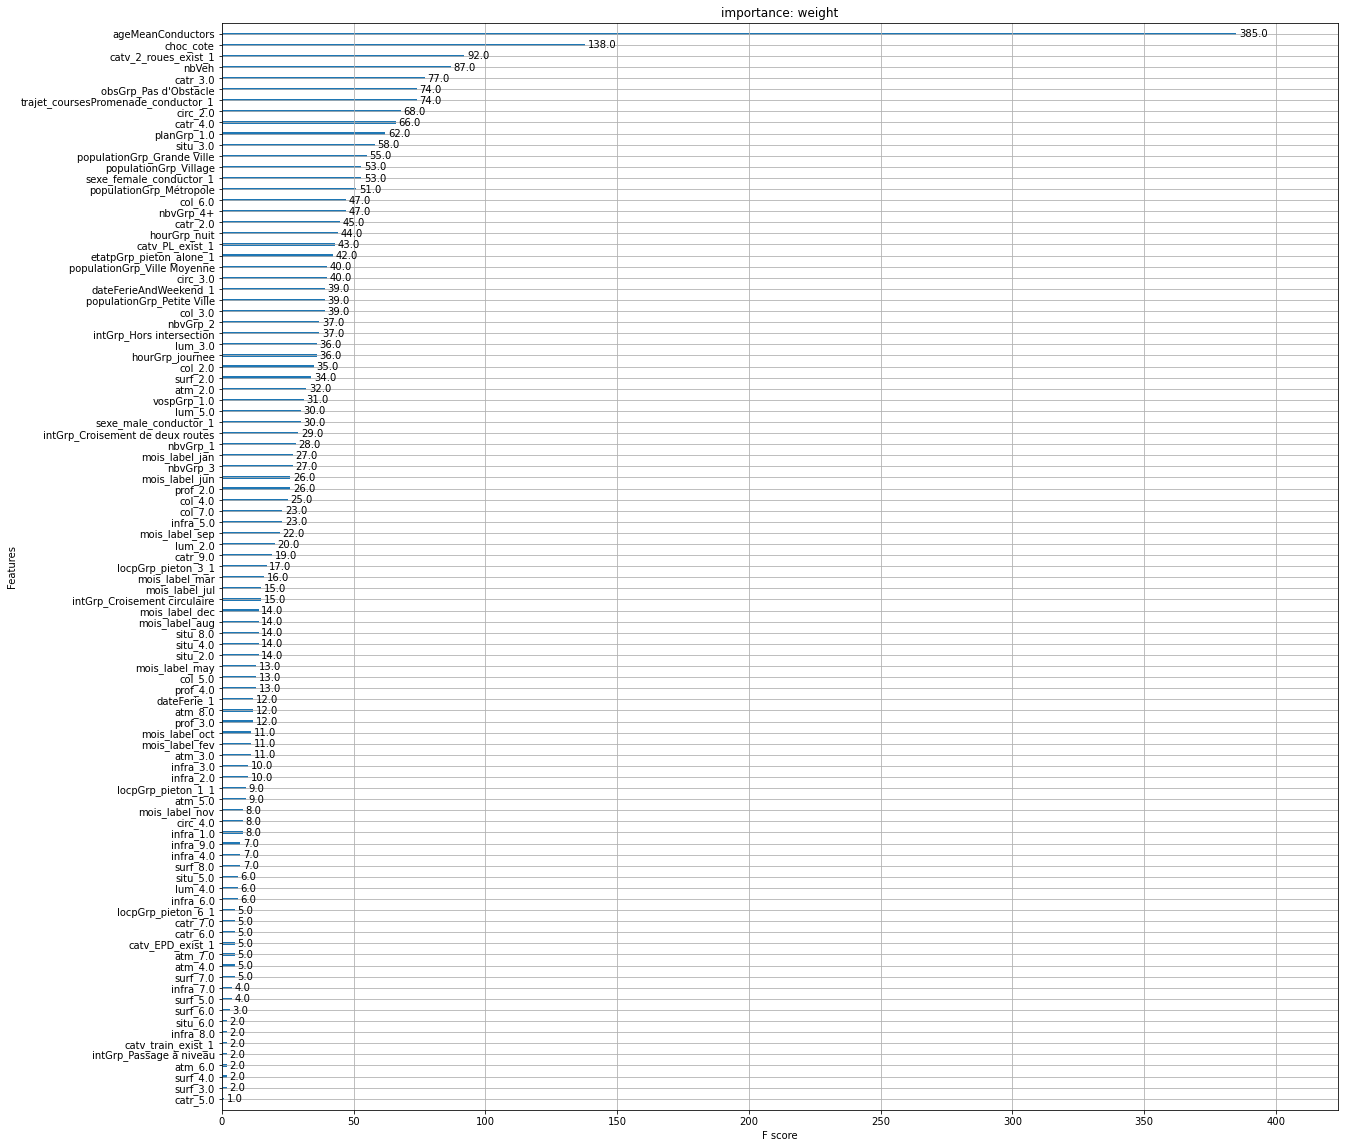

In [111]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgb1, max_num_features=97, importance_type='weight', title='importance: weight', ax=ax);

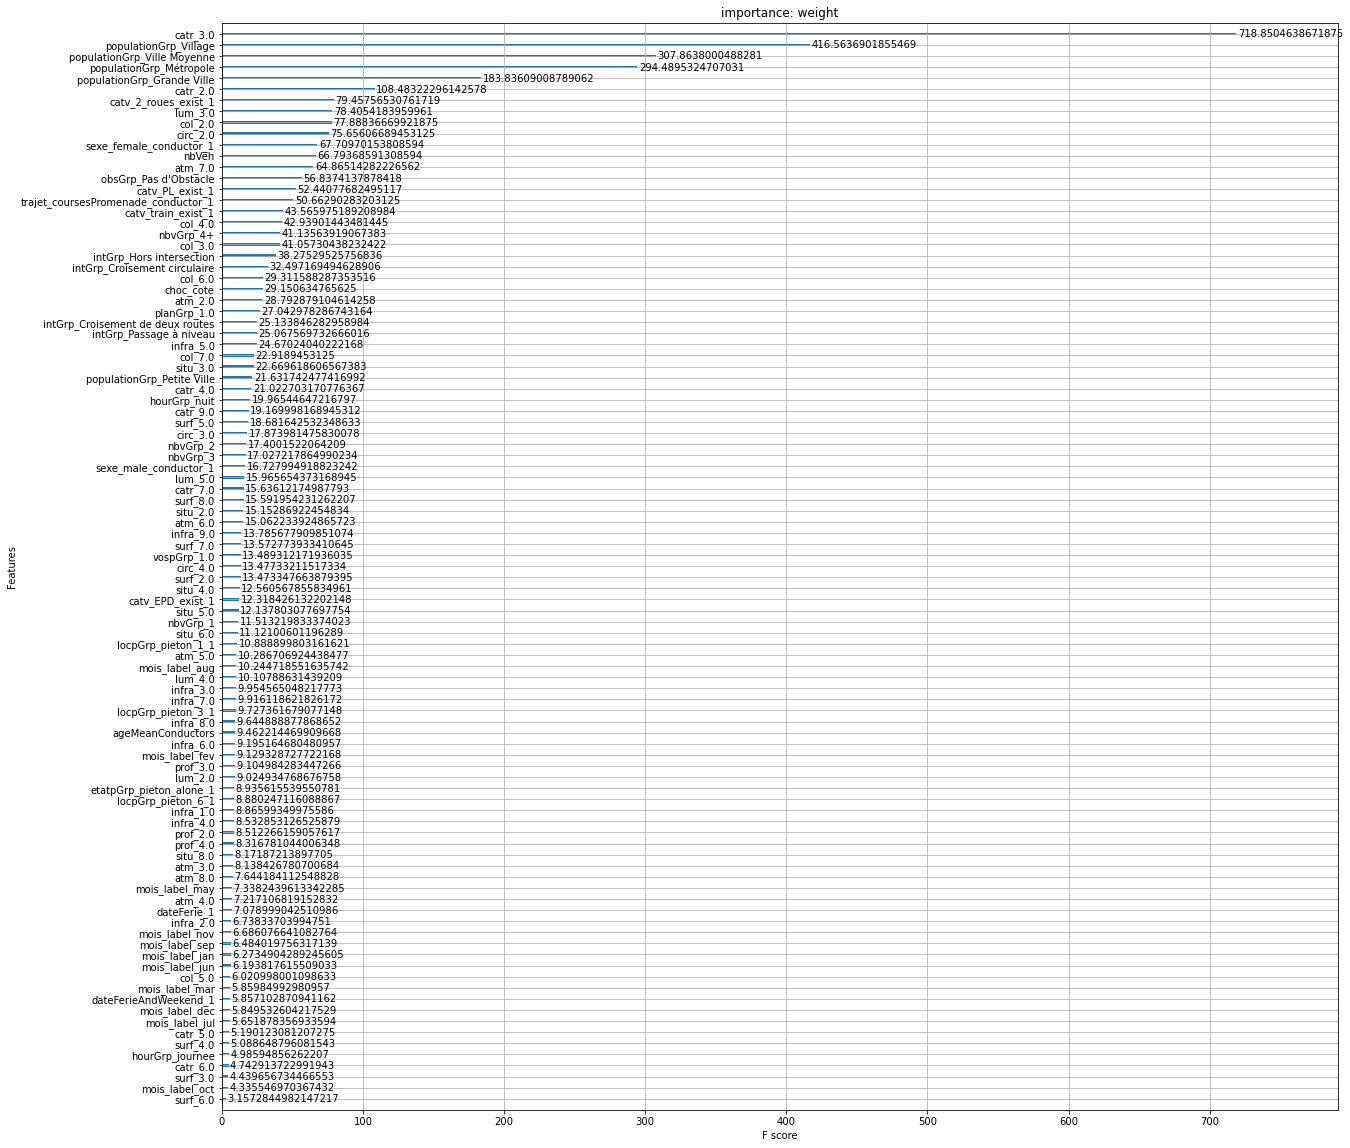

In [112]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgb1, max_num_features=97, importance_type='gain', title='importance: weight', ax=ax);

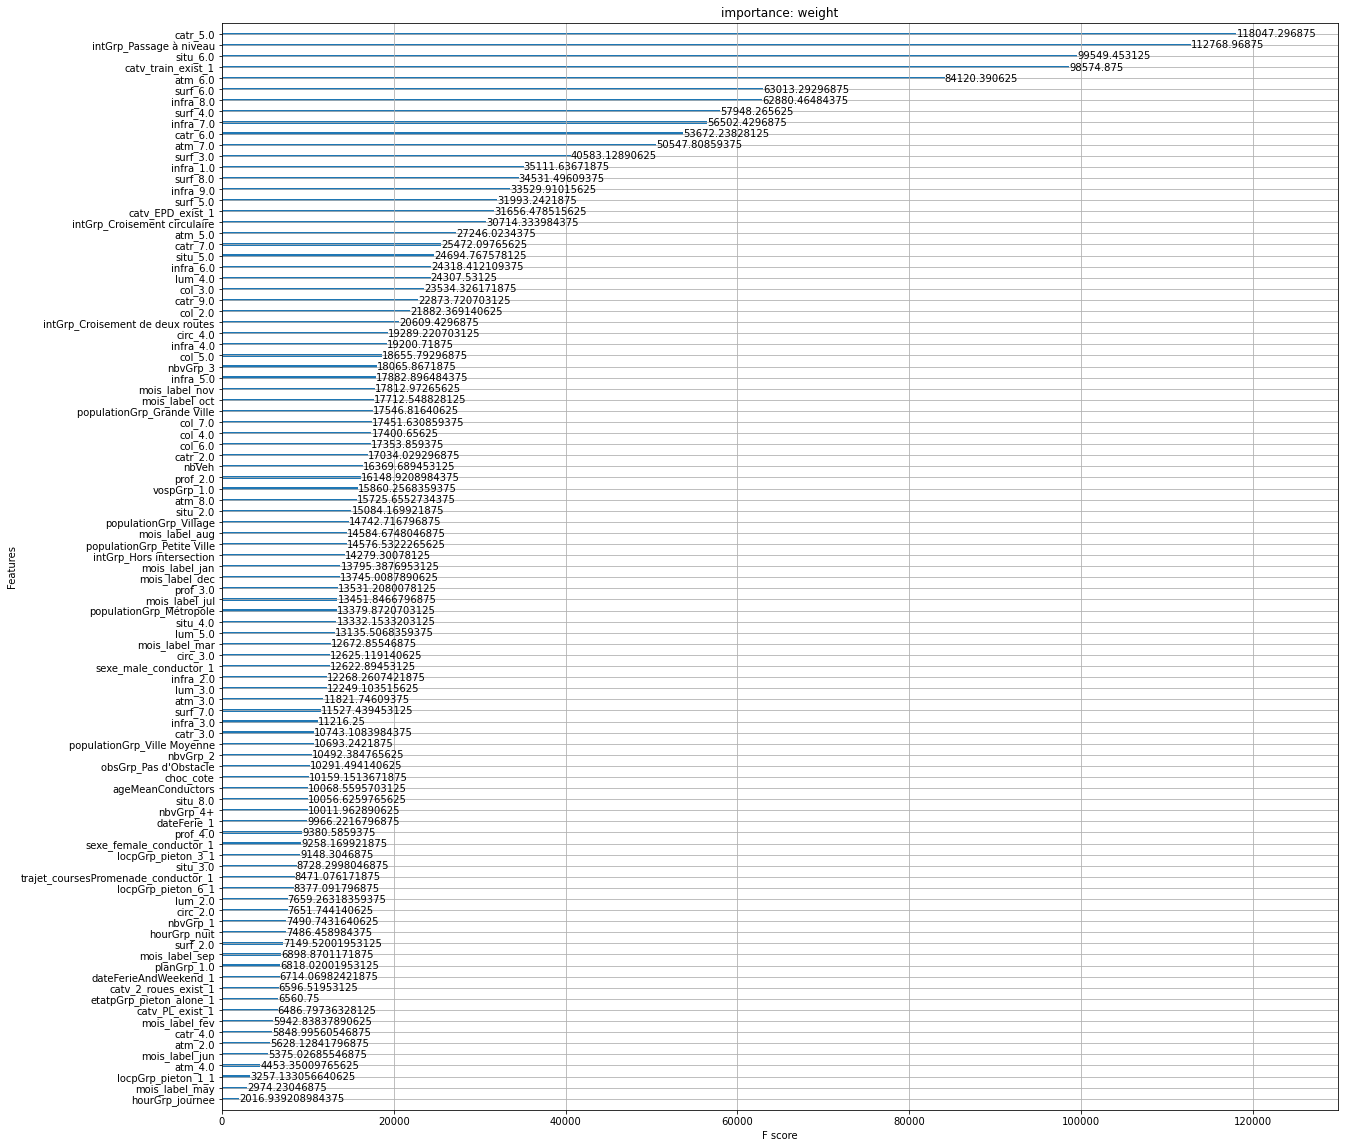

In [113]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgb1, max_num_features=97, importance_type='cover', title='importance: weight', ax=ax);

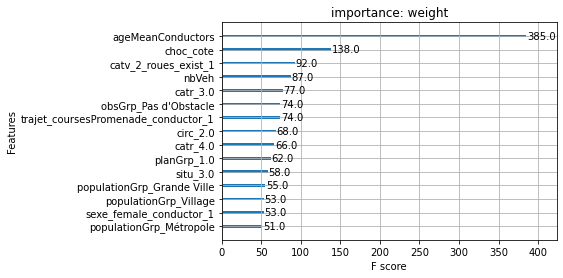

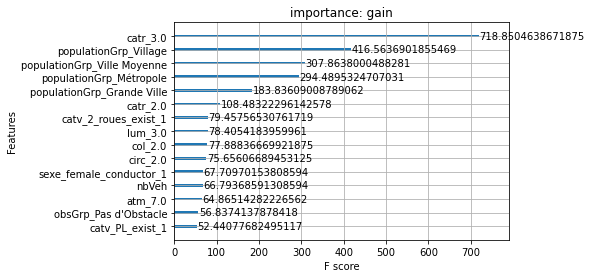

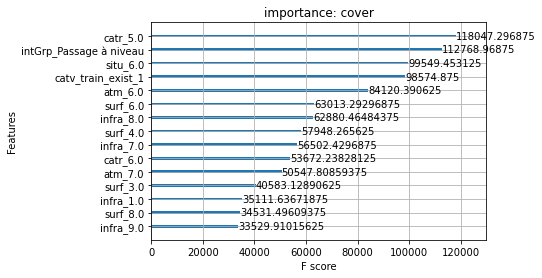

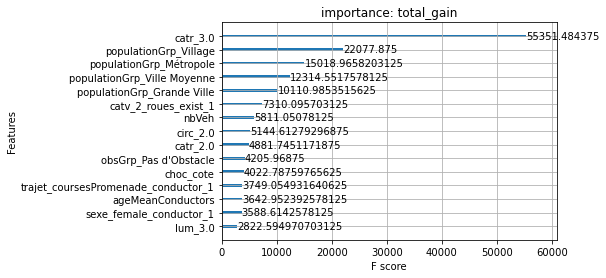

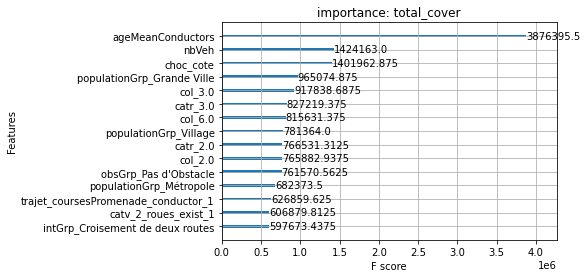

In [104]:
types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb1, max_num_features=15, importance_type=f, title='importance: '+f);

In [74]:
# Train
xgb_preds_train = xgb1.predict(train)
xgb_preds_train_bin = np.where(xgb_preds_train >= 0.5, 1, 0)
# Test
xgb_preds_test = xgb1.predict(test)
xgb_preds_test_bin = np.where(xgb_preds_test >= 0.5, 1, 0)

In [47]:
### From probabilities to binary
# Train
xgb_preds_train_bin = []

for i in xgb_preds_train:
    if i>=0.5:
        xgb_preds_train_bin.append(1)
    if i<0.5:
        xgb_preds_train_bin.append(0)

# Test
xgb_preds_test_bin = []
for i in xgb_preds_test:
    if i>=0.5:
        xgb_preds_test_bin.append(1)
    if i<0.5:
        xgb_preds_test_bin.append(0)

In [49]:
# Train contingency table
pd.crosstab(y_train, xgb_preds_train_bin, colnames=['xgb_pred_train'], normalize=True)

xgb_pred_train,0,1
gravGrp_2_34,,
0,0.484385,0.092215
1,0.164878,0.258522


In [95]:
# Test contingency table
pd.crosstab(y_test, xgb_preds_test_bin, colnames=['xgb_pred_test'], normalize=True)

xgb_pred_test,0,1
gravGrp_2_34,,
0,0.480154,0.096832
1,0.170730,0.252285


In [96]:
# Performance criteria
print(classification_report(y_train.astype('int'), xgb_preds_train_bin))
print(classification_report(y_test.astype('int'), xgb_preds_test_bin))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79    385885
           1       0.74      0.61      0.67    283357

    accuracy                           0.74    669242
   macro avg       0.74      0.73      0.73    669242
weighted avg       0.74      0.74      0.74    669242

              precision    recall  f1-score   support

           0       0.74      0.83      0.78     96536
           1       0.72      0.60      0.65     70775

    accuracy                           0.73    167311
   macro avg       0.73      0.71      0.72    167311
weighted avg       0.73      0.73      0.73    167311



In [97]:
rmse_train = np.sqrt(mean_squared_error(y_train, xgb_preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, xgb_preds_test))
print("RMSE train: %f" % (rmse_train))
print("RMSE test : %f" % (rmse_test))

RMSE train: 0.420164
RMSE test : 0.428119


In [100]:
# AUC
fpr_xgb, tpr_xgb, seuils = roc_curve(y_test.astype('int'), xgb_preds_test, pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb

0.785840317572817

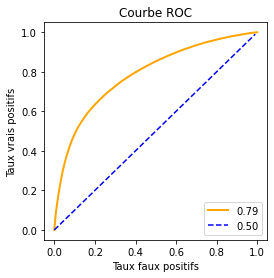

In [101]:
# ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=round(roc_auc_xgb, 2))
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'b--', label='0.50')
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right');

### Logistic regression
- Sensitivte to multi-collinearity
- Doesn't work with NA values
- Only floats for predictions so a pd.get_dummies is required
- Standardization helps to not mislead variables range with their weight

In [90]:
# Defining target and features
# target_lr = dfPoolMLCCA.gravGrp_2_34
# features_lr = dfPoolMLCCA.drop('gravGrp_2_34', axis=1)
# features_matrix_lr = pd.get_dummies(features_lr, drop_first=True)

In [40]:
### Splitting into train & test
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_matrix, target, test_size=0.2, random_state=1)

In [41]:
# LR model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

In [42]:
pd.crosstab(y_train, lr_pred_train>=0.5, normalize=True)

col_0,False,True
gravGrp_2_34,,
0,0.472154,0.104447
1,0.186057,0.237343


In [43]:
pd.crosstab(y_test, lr_pred_test>=0.5, normalize=True)

col_0,False,True
gravGrp_2_34,,
0,0.472617,0.104369
1,0.186216,0.236799


In [44]:
# Performance criteria
print(classification_report(y_train, lr_pred_train>=0.5))
print(classification_report(y_test, lr_pred_test>=0.5))

              precision    recall  f1-score   support

           0       0.72      0.82      0.76    385885
           1       0.69      0.56      0.62    283357

    accuracy                           0.71    669242
   macro avg       0.71      0.69      0.69    669242
weighted avg       0.71      0.71      0.70    669242

              precision    recall  f1-score   support

           0       0.72      0.82      0.76     96536
           1       0.69      0.56      0.62     70775

    accuracy                           0.71    167311
   macro avg       0.71      0.69      0.69    167311
weighted avg       0.71      0.71      0.70    167311



In [45]:
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

feats = list(X_train.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,0.595061
choc_cote,0.046493
ageMeanConductors,0.001589
num_veh,-0.072932
prof,0.018228
planGrp,0.048474
surf,-0.018572
atm,0.006432
vospGrp,0.001787
catv_EPD_exist,-0.152136


In [46]:
print(lr.score(X_train, y_train))
print(model_selection.cross_val_score(lr, X_train, y_train).mean())

0.19462236436457214
0.1944621291444707


In [48]:
# AUC
fpr, tpr, seuils = roc_curve(y_test, lr_pred_test, pos_label=1)
roc_auc = auc(fpr, tpr)
roc_auc

0.7503078211734161

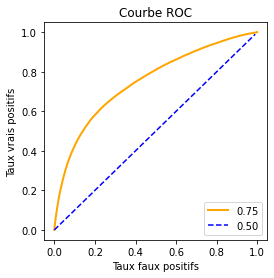

In [49]:
# ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='orange', lw=2, label=round(roc_auc, 2))
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'b--', label='0.50')
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right');